# A notebook for exploring how best to measure the change in Mtb

In [1]:
import napari
from macrohet import dataio, tile, tools, visualise
import numpy as np
import os

def view(img):
    return napari.Viewer().add_image(img)

from tqdm.auto import tqdm

import btrack
import dask.array as da

from skimage.transform import rescale, resize, downscale_local_mean

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")
sns.set_palette("Spectral")

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from skimage import io, transform

### Load all metadata

Both the image metadata and the assay layout metadata

In [2]:
%%time
# base_dir = '/mnt/DATA/macrohet/'
base_dir = '/Volumes/lab-gutierrezm/home/users/dayn/macrohet_nemo/'
metadata_fn = os.path.join(base_dir, 'macrohet_images/PS0000/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!
CPU times: user 8.07 s, sys: 1.62 s, total: 9.69 s
Wall time: 24 s


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [3]:
%%time
metadata_path = os.path.join(base_dir, 'macrohet_images/PS0000/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!
CPU times: user 10 ms, sys: 3.69 ms, total: 13.7 ms
Wall time: 215 ms


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

# Iteratively load all tracks

and append to a track_dict dictionary

In [6]:
tracks_dict = dict()
### iterate over all experimental conditions
for (row, column), info in tqdm(assay_layout.iterrows(), 
                                desc = 'Progress through positions',
                                total = len(assay_layout)):

    ### load tracks
    with btrack.io.HDF5FileHandler(os.path.join(base_dir, 
                                                f'labels/macrohet_seg_model/{row,column}.h5'), 
                                       'r', 
                                       obj_type='obj_type_1'
                                       ) as reader:
        tracks = reader.tracks
            
    ### append tracks to dictionary
    tracks_dict[(row, column)] = tracks

Progress through positions:   0%|          | 0/24 [00:00<?, ?it/s]

[INFO][2023/07/14 01:43:20 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 4).h5...
[INFO][2023/07/14 01:43:20 PM] Loading tracks/obj_type_1
[INFO][2023/07/14 01:43:20 PM] Loading LBEP/obj_type_1
[INFO][2023/07/14 01:43:20 PM] Loading objects/obj_type_1 (39878, 5) (39878 filtered: None)
[INFO][2023/07/14 01:43:20 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 4).h5
[INFO][2023/07/14 01:43:20 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5...
[INFO][2023/07/14 01:43:20 PM] Loading tracks/obj_type_1
[INFO][2023/07/14 01:43:20 PM] Loading LBEP/obj_type_1
[INFO][2023/07/14 01:43:20 PM] Loading objects/obj_type_1 (41424, 5) (41424 filtered: None)
[INFO][2023/07/14 01:43:21 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5
[INFO][2023/07/14 01:43:21 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 6).h5...
[INFO][2023/07/14 01:43:21 PM] Loading tracks/obj_type_1
[INFO]

[INFO][2023/07/14 01:43:38 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5
[INFO][2023/07/14 01:43:38 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 6).h5...
[INFO][2023/07/14 01:43:38 PM] Loading tracks/obj_type_1
[INFO][2023/07/14 01:43:38 PM] Loading LBEP/obj_type_1
[INFO][2023/07/14 01:43:38 PM] Loading objects/obj_type_1 (45688, 5) (45688 filtered: None)
[INFO][2023/07/14 01:43:39 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 6).h5
[INFO][2023/07/14 01:43:39 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5...
[INFO][2023/07/14 01:43:39 PM] Loading tracks/obj_type_1
[INFO][2023/07/14 01:43:39 PM] Loading LBEP/obj_type_1
[INFO][2023/07/14 01:43:39 PM] Loading objects/obj_type_1 (45214, 5) (45214 filtered: None)
[INFO][2023/07/14 01:43:39 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5
[INFO][2023/07/14 01:43:39 PM] Opening HDF file: /mnt/DATA/macrohe

# Compile all longer length tracks into dataframe

Add extra information such as the MSD of cells between frames

In [7]:
%%time

df = pd.read_pickle(os.path.join(base_dir,'results/preliminary_sc_measures/sc_dfs/sc_df_40_interp.pkl'))
df

CPU times: user 135 ms, sys: 109 ms, total: 243 ms
Wall time: 251 ms


,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID,Technical replicate,dMtb
0,0,708.125061,77.589088,3568.950308,391.049006,0.0,0.0,1.0,42556.0,365.408905,...,0.813310,0.000000,RD1,CTRL,EC0,433,"(3, 4)",433.3.4,1.0,0.095232
1,1,725.449097,73.245003,3656.263447,369.154814,0.0,0.0,1.0,48727.0,362.852478,...,0.896474,17.860383,RD1,CTRL,EC0,433,"(3, 4)",433.3.4,1.0,0.095232
2,2,723.088928,76.431496,3644.368198,385.214738,0.0,0.0,1.0,43484.0,363.515442,...,0.876911,3.965367,RD1,CTRL,EC0,433,"(3, 4)",433.3.4,1.0,0.095232
3,3,726.009766,79.395073,3659.089219,400.151168,0.0,0.0,1.0,39113.0,360.448578,...,0.717504,4.161019,RD1,CTRL,EC0,433,"(3, 4)",433.3.4,1.0,0.095232
4,4,728.209656,82.197769,3670.176665,414.276757,0.0,0.0,1.0,32644.0,362.289764,...,0.425791,3.562951,RD1,CTRL,EC0,433,"(3, 4)",433.3.4,1.0,0.095232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701474,70,757.886719,44.412071,3819.749063,223.836839,1.0,1.0,1.0,71808.0,358.460327,...,0.923363,0.522451,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9,2.0,-0.000019
701475,71,760.801514,49.459522,3834.439629,249.275992,1.0,1.0,1.0,65328.0,358.026184,...,0.893735,5.828618,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9,2.0,-0.000019
701476,72,761.494873,50.097046,3837.934160,252.489111,1.0,1.0,1.0,66829.0,358.846039,...,0.888738,0.941904,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9,2.0,-0.000019
701477,73,759.911255,48.538654,3829.952725,244.634818,1.0,1.0,1.0,71877.0,358.451752,...,0.897926,2.221808,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9,2.0,-0.000019


### Renaming delta Mtb method of choice for ease of use

In [8]:
df['dMtb'] = df['delta Mtb max fold-change normalised max area']

# Style

In [623]:
sns.set(font='Nimbus Sans', style = 'white')

### Old style

In [10]:
sns.color_palette('PiYG')

[(0.8129181084198386, 0.2544405997693195, 0.5693194925028835),
 (0.9348712033833141, 0.6798154555940021, 0.8312187620146096),
 (0.9856978085351787, 0.9031910803537101, 0.9458669742406767),
 (0.9202614379084968, 0.9629373317954633, 0.8576701268742792),
 (0.6908881199538641, 0.8624375240292197, 0.4883506343713959),
 (0.38269896193771624, 0.6403690888119954, 0.18108419838523643)]

In [11]:
colors = ['#013220',#'#008B8B',#(0.204*0.8, 0.330*0.8, 0.706*0.8), 
          sns.color_palette('PiYG')[0], sns.color_palette('PiYG')[-1]]
colors

['#013220',
 (0.8129181084198386, 0.2544405997693195, 0.5693194925028835),
 (0.38269896193771624, 0.6403690888119954, 0.18108419838523643)]

### New style

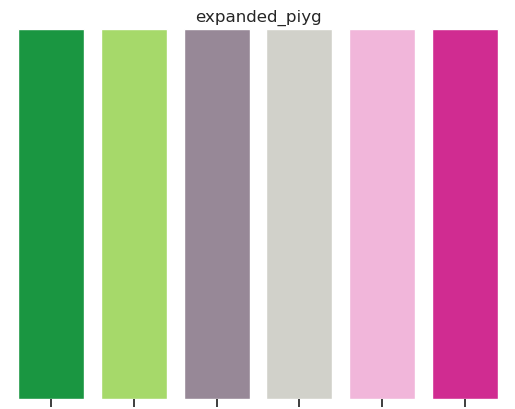

['#1a9641', '#a6d96a', '#978897', '#d1d1ca', '#f1b6da', '#d02c91']


In [621]:
# Get the color palette of the PiYG color map
expanded_piyg = visualise.color_palette('expanded_piyg').colors

sns.set_palette(expanded_piyg)

# Display the colors in the PiYG color map
visualise.show_colors('expanded_piyg')
print(expanded_piyg)


In [729]:
expanded_piyg_dict

{'CTRL': '#1a9641',
 'RD1': '#d02c91',
 'BDQ': '#1a9641',
 'INH': '#a6d96a',
 'PZA': '#f1b6da',
 'RIF': '#d02c91'}

# Output

In [13]:
output_dir = os.path.join(base_dir, 'results/preliminary_sc_measures/sc_graphs/dmtb_all_conditions')
os.makedirs(output_dir, exist_ok = True)

# How many cells are truly permissive ie deltaMtb>0

#### What do the different distributions of deltaMtb look like?

In [611]:
df_delta_mtb = df.drop_duplicates(subset=['delta Mtb raw', 'delta Mtb max raw','delta Mtb max smooth', 'delta Mtb max fold-change'])
df_delta_mtb

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID,Technical replicate,dMtb,Compound/Strain
0,0,708.125061,77.589088,3568.950308,391.049006,0.0,0.0,1.0,42556.0,365.408905,...,0.0,RD1,CTRL,EC0,433,"(3, 4)",433.3.4,1.0,0.095232,RD1
42,0,261.683105,4.945100,1318.882852,24.923306,0.0,0.0,0.0,6754.0,355.006958,...,0.0,RD1,CTRL,EC0,424,"(3, 4)",424.3.4,1.0,-0.000112,RD1
89,0,349.589508,8.074520,1761.931121,40.695581,0.0,0.0,0.0,13672.0,344.202454,...,0.0,RD1,CTRL,EC0,425,"(3, 4)",425.3.4,1.0,0.000000,RD1
152,0,457.172943,8.791715,2304.151633,44.310242,1.0,1.0,0.0,20542.0,343.157196,...,0.0,RD1,CTRL,EC0,426,"(3, 4)",426.3.4,1.0,0.000586,RD1
226,0,663.630920,10.924337,3344.699839,55.058660,0.0,0.0,0.0,20098.0,353.067780,...,0.0,RD1,CTRL,EC0,427,"(3, 4)",427.3.4,1.0,0.000544,RD1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701271,33,660.136597,577.060730,3327.088447,2908.386079,0.0,0.0,0.0,47448.0,377.264587,...,0.0,WT,BDQ,EC99,2297,"(6, 9)",2297.6.9,2.0,0.000032,BDQ
701313,33,224.372467,131.369995,1130.837234,662.104775,1.0,1.0,1.0,98867.0,373.245178,...,0.0,WT,BDQ,EC99,2292,"(6, 9)",2292.6.9,2.0,-0.000153,BDQ
701355,33,1106.007935,1032.619019,5574.279990,5204.399854,0.0,0.0,1.0,53641.0,366.914032,...,0.0,WT,BDQ,EC99,2286,"(6, 9)",2286.6.9,2.0,0.000089,BDQ
701397,34,477.689026,538.676697,2407.552690,2714.930552,0.0,0.0,0.0,36503.0,356.196930,...,0.0,WT,BDQ,EC99,2324,"(6, 9)",2324.6.9,2.0,0.000167,BDQ


In [320]:
df_delta_mtb.groupby(['Strain', 'Compound', 'Concentration']).size().reset_index().rename(columns={0: 'count'})


,Strain,Compound,Concentration,count
0,RD1,CTRL,EC0,1344
1,WT,BDQ,EC50,908
2,WT,BDQ,EC99,684
3,WT,CTRL,EC0,1934
4,WT,INH,EC50,842
5,WT,INH,EC99,817
6,WT,PZA,EC50,918
7,WT,PZA,EC99,901
8,WT,RIF,EC50,817
9,WT,RIF,EC99,863


In [612]:
for index, row_ in df_delta_mtb.iterrows():
    cell_ID = row_['Cell ID']
    row, column = row_['Acquisition ID']
    online_fn = f'https://macrohet.s3.eu-west-2.amazonaws.com/{row},{column}/glimpse_{cell_ID}.{row}.{column}_t0.png'
    df_delta_mtb.at[index, 'glimpse_url'] = online_fn
    t0 = row_['Time (hours)']
    df_delta_mtb.at[index, 'glimpse_url_t0'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{t0}.png'
    df_delta_mtb.at[index, 'glimpse_url_tn'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{-1}.png'

# Creating static plot showing dMtb across one condition

In [613]:
# Assuming your DataFrame is named 'df'
df_delta_mtb['Strain/Compound'] = df_delta_mtb['Compound']  # Create a new column and copy values from 'Compound'

# Replace values in 'NewColumn' where 'Strain' is 'RD1' with 'RD1'
df_delta_mtb.loc[df_delta_mtb['Strain'] == 'RD1', 'Strain/Compound'] = 'RD1'


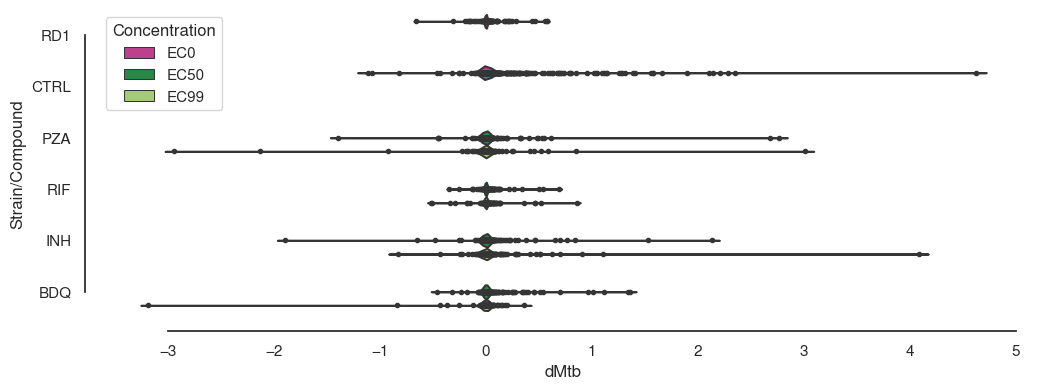

In [162]:
plt.figure(figsize=(12, 4))

sns.violinplot(x="dMtb", y="Strain/Compound",
            hue="Concentration", 
            palette=[expanded_piyg[-1], expanded_piyg[0], expanded_piyg[1]],
            data=df_delta_mtb, 
            fliersize=15, 
#             scale = 'width', 
            inner = 'point', 
#             width=1.1
#             scale = 'area', scale_hue=True
#             gridsize = 10
              )
# plt.xlim(-1, 5)


sns.despine(offset=10, trim=True)

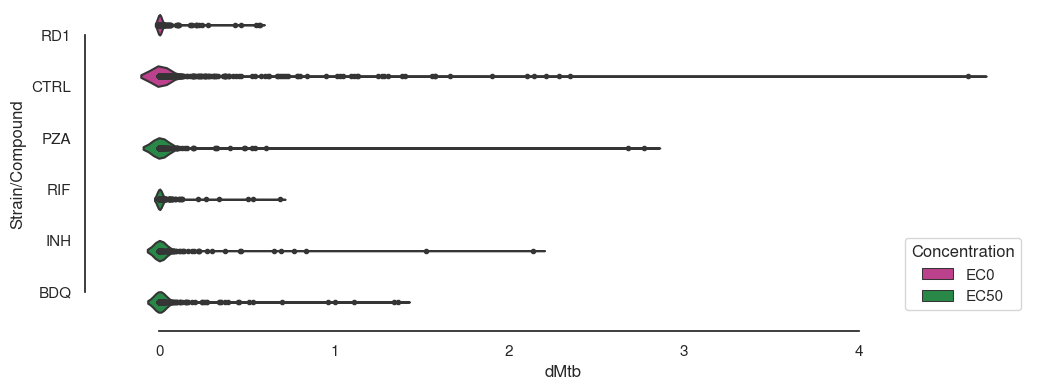

In [154]:
plt.figure(figsize=(12, 4))

sns.violinplot(x="dMtb", y="Strain/Compound",
            hue="Concentration", 
            palette=[expanded_piyg[-1], expanded_piyg[0], expanded_piyg[1]],
            data=df_delta_mtb[(df_delta_mtb['Concentration'] != 'EC99') & (df_delta_mtb['dMtb'] >0)], 
            fliersize=15, 
#             scale = 'width', 
            inner = 'point', 
#             width=1.1
#             scale = 'area', scale_hue=True
#             gridsize = 10
              )
# plt.xlim(-1, 5)


sns.despine(offset=10, trim=True)

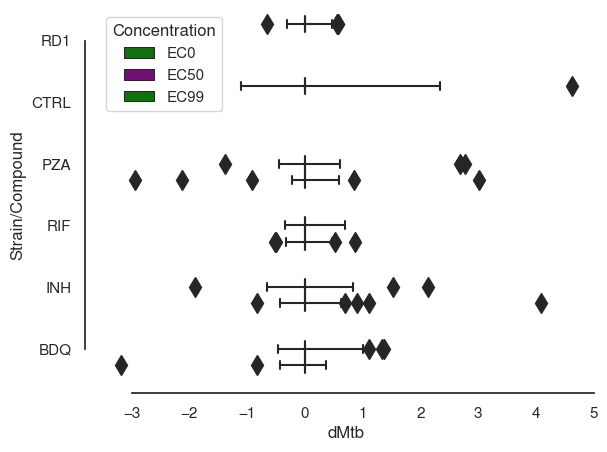

In [79]:
sns.boxplot(x="dMtb", y="Strain/Compound",
            hue="Concentration", 
            palette=[expanded_piyg[-1], expanded_piyg[0], expanded_piyg[2]],
            data=df_delta_mtb, 
            fliersize=10, whis = 2000) #  whis is 2000 times the interquartile range here!

sns.despine(offset=10, trim=True)

# Just plot KDE, then cropped, then highlight, then etc etc

In [781]:
# df_delta_mtb = df_delta_mtb.drop(41983) # drop the original control (false track)
# df_delta_mtb = df_delta_mtb.drop(613711) # drop the original pza (false track)
# df_delta_mtb = df_delta_mtb.drop(657222) # drop the original INH (false track)
# df_delta_mtb = df_delta_mtb.drop(36197) # drop the ctrl cos i dont like the mask in it lol
# df_delta_mtb = df_delta_mtb.drop(34092) # again
# df_delta_mtb = df_delta_mtb.drop(136595) # drop inh cos border 
### shall i drop ones with no initial mtb in?
df_delta_mtb = df_delta_mtb.drop(34737) # ctrl with no initial mtb
df_delta_mtb = df_delta_mtb.drop(621101) #inh '' 
df_delta_mtb = df_delta_mtb.drop(135727) # rif ''


In [786]:
for i in [357011, 101552, 651955]:
    df_delta_mtb = df_delta_mtb.drop(i)

In [790]:
for i in [391455, 299728, 664871]:
    df_delta_mtb = df_delta_mtb.drop(i)

In [794]:
for i in [312718, 335478, 467888, 571578]:
    df_delta_mtb = df_delta_mtb.drop(i)

In [798]:
for i in [113568, 138052, 158688, 577358]:
    df_delta_mtb = df_delta_mtb.drop(i)

In [802]:
for i in [173272, 452902, 404030]:
    df_delta_mtb = df_delta_mtb.drop(i)

In [806]:
for i in [337950, 224457]:
    df_delta_mtb = df_delta_mtb.drop(i)

In [810]:
df_delta_mtb = df_delta_mtb.drop(412458)

In [814]:
df_delta_mtb = df_delta_mtb.drop(410056)

In [818]:
df_delta_mtb = df_delta_mtb.drop(234641)

In [823]:
df_delta_mtb = df_delta_mtb.drop(216660)

In [828]:
df_delta_mtb = df_delta_mtb.drop(403159)

In [833]:
df_delta_mtb = df_delta_mtb.drop(581095)

In [838]:
df_delta_mtb = df_delta_mtb.drop(222715)

In [906]:
df_delta_mtb = df_delta_mtb.drop(396955)

In [911]:
df_delta_mtb = df_delta_mtb.drop(559545)

In [912]:
# Find the maximum value of df_delta_mtb['dMtb'] for each unique value of df_delta_mtb['Compound/Strain']
max_values = df_delta_mtb.groupby('Compound/Strain')['dMtb'].transform('max')

# Create a new DataFrame with only the rows that contain the maximum values
df_max_dmtb = df_delta_mtb[df_delta_mtb['dMtb'] == max_values]


In [913]:
df_max_dmtb

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Cell ID,Acquisition ID,Unique ID,Technical replicate,dMtb,Compound/Strain,glimpse_url,glimpse_url_t0,glimpse_url_tn,Strain/Compound
69880,0,883.031555,1056.135254,4450.479038,5322.921680,1.0,1.0,1.0,12569.0,377.961823,...,299,"(3, 6)",299.3.6,1.0,2.769864,PZA,"https://macrohet.s3.eu-west-2.amazonaws.com/3,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...,PZA
342074,0,120.401482,502.807220,606.823467,2534.148391,1.0,1.0,1.0,31181.0,431.182739,...,485,"(4, 9)",485.4.9,2.0,0.703229,BDQ,"https://macrohet.s3.eu-west-2.amazonaws.com/4,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...,BDQ
387703,0,696.864319,244.091553,3512.196167,1230.221426,1.0,1.0,1.0,22867.0,394.712646,...,396,"(5, 5)",396.5.5,3.0,1.129769,CTRL,"https://macrohet.s3.eu-west-2.amazonaws.com/5,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...,CTRL
448487,0,1017.646362,69.463081,5128.937666,350.093930,1.0,1.0,1.0,36637.0,381.432587,...,460,"(5, 7)",460.5.7,1.0,0.465466,RIF,"https://macrohet.s3.eu-west-2.amazonaws.com/5,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...,RIF
533683,0,993.871277,588.351807,5009.111235,2965.293105,1.0,1.0,1.0,15924.0,413.437317,...,592,"(6, 4)",592.6.4,4.0,0.577751,RD1,"https://macrohet.s3.eu-west-2.amazonaws.com/6,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...,RD1
670249,9,315.278290,989.525024,1589.002581,4987.206123,1.0,1.0,1.0,72625.0,377.904724,...,1487,"(6, 8)",1487.6.8,2.0,0.696501,INH,"https://macrohet.s3.eu-west-2.amazonaws.com/6,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...,INH


In [848]:
import matplotlib.patches as patches
import string
alphabet_dict = {index:letter for index, letter in enumerate(string.ascii_uppercase)}

In [909]:
alphabet_dict_2 = {'RD1': 'A',
                   'CTRL': 'B',
                   'PZA': 'C',
                   'RIF': 'D',
                   'INH': 'E',
                   'BDQ': 'F'}


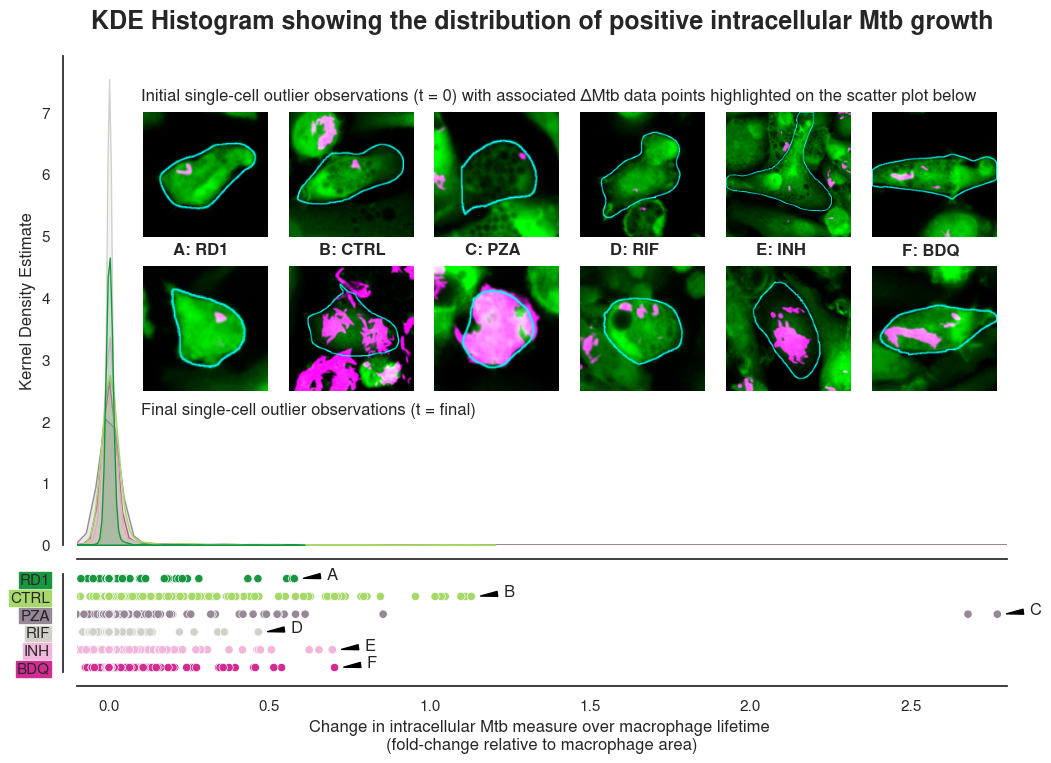

In [939]:
sns.set(font='Nimbus Sans', style = 'white')
sns.set_palette(expanded_piyg)

# Set the desired figure size and height ratios
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(12,8), gridspec_kw={'height_ratios': [5, 1]})
plt.rc('legend', loc="upper left", )

# Plot the KDE plot on ax1
kde_plot = sns.kdeplot(data=df_delta_mtb, x='dMtb', hue='Compound/Strain', ax=ax1, linewidth = 1, alpha = 0.2, fill = True, legend=False
                      )

# Plot the scatter plot on ax2
scatter_plot = sns.scatterplot(data=df_delta_mtb, x='dMtb', y='Compound/Strain', hue='Compound/Strain', ax=ax2, legend=False)

# Remove y-axis labels for ax2
ax2.set_ylabel('')
# Remove y-axis labels for ax1
ax1.set_ylabel('Kernel Density Estimate')

# Set x-axis limits
# ax1.set_xlim(-1.05, 5)
ax1.set_xlim(-0.1, 2.8)

# ax1.set_ylim(0,4)

# # set vertical line at origin
# ax1.vlines(x = 0, ymin = 0, ymax = kde_plot.dataLim.height*1.1, 
#            linestyles='dashed', color='black', linewidth = 0.5)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.1)

# iterate over 6 of the top outliers
# for n, (i, row_) in enumerate(df_max_dmtb.iterrows()):
## this way iterates over in the same order as the y axis
for n, sc in enumerate((df_delta_mtb['Strain/Compound'].unique().tolist())):
    # extract 
    row_ = df_max_dmtb[df_max_dmtb['Strain/Compound'] == sc]
    # load both images into memory
    img_t0 = io.imread(row_['glimpse_url_t0'].iloc[0])
    img_tn = io.imread(row_['glimpse_url_tn'].iloc[0])
    # Resize the images to 100x100 pixels
    img_t0 = transform.resize(img_t0, (150, 150), anti_aliasing=True)
    img_tn = transform.resize(img_tn, (150, 150), anti_aliasing=True)
    # add images
    imagebox = OffsetImage(img_t0, zoom = 0.6)
    # add coords for t0 images
    x = n/2.2+0.3#len(df_max_dmtb)-(n*0.8)-1.5
    y = 6
    coords = x, y
    ab = AnnotationBbox(imagebox, xy=coords, frameon = False)
    ax1.add_artist(ab)
    imagebox = OffsetImage(img_tn, zoom = 0.6)
    # add coords for tn images
    y = y - 2.5
    coords = x, y
    ab = AnnotationBbox(imagebox, xy=coords, frameon = False)
    ax1.add_artist(ab)
    # add labels
    label = f'{alphabet_dict[n]}: '+row_['Compound/Strain'].iloc[0]
    ax1.text(x = coords[0]-0.1, y = y+1.2, s = label, weight = 'bold')
    # add labels as separate entities
#     label1 = f'{alphabet_dict[n]}:'
#     label2 = row_['Compound/Strain'].iloc[0]
#     ax1.text(x = coords[0]-0.155, y = y+1.2, s = label1)
#     ax1.text(x = coords[0]-0.1, y = y+1.2, s = label2, weight = 'bold')

ax1.text(x =0.1, y = 7.2, s = 'Initial single-cell outlier observations (t = 0) with associated ΔMtb data points highlighted on the scatter plot below', rotation = 0,)# fontsize = 12)
ax1.text(x =0.1, y = 2.12, s = 'Final single-cell outlier observations (t = final)', rotation = 0,)# fontsize = 9)

# ax1.text(x=0.13, y=2.5, s='Single-cell measurements are shown below, whilst images of the greatest ΔMtb outliers are shown above', 
#         fontsize=9)

ax2.set_xlabel('Change in intracellular Mtb measure over macrophage lifetime \n(fold-change relative to macrophage area)')
# Remove spines and trim
sns.despine(offset=10, )
# set title
title_text = 'KDE Histogram showing the distribution of positive intracellular Mtb growth'
title = ax1.set_title(title_text, y=1.04)
# title.set_text(title_text)
title.set_fontsize(18)
title.set_fontweight('heavy')
#save fig
# plt.savefig(os.path.join(output_dir, 'KDE_dMtb_sc_eg.pdf'), transparent = True, 
#             dpi = 314, bbox_inches = 'tight')
plt.draw()


# Iterate over y-axis labels on ax2
for n,label in enumerate(ax2.get_yticklabels()):
    # Get the label text
    text = label.get_text()
    
    # Get the color associated with the label
    color = expanded_piyg[n]
    
    # Create a colored rectangle patch
    rect = patches.Rectangle((0, 0), 10, 10, facecolor=color, edgecolor='none')
    
    # Add the rectangle patch next to the label
    label.set_bbox(dict(boxstyle='square', pad=0.05, facecolor=color, edgecolor=color, linewidth=1))

# Find the maximum value for each hue category
max_values = df_delta_mtb.groupby('Compound/Strain')['dMtb'].max()

# Iterate over the hue categories
for n, hue_category in enumerate(max_values.index):
    # Get the maximum value for the hue category
    max_value = max_values[hue_category]
    
    # Get the x and y coordinates for the maximum value
    x = df_delta_mtb.loc[(df_delta_mtb['Compound/Strain'] == hue_category) & (df_delta_mtb['dMtb'] == max_value), 'dMtb'].values[0]
    y = df_delta_mtb.loc[(df_delta_mtb['Compound/Strain'] == hue_category) & (df_delta_mtb['dMtb'] == max_value), 'Compound/Strain'].values[0]
    
    # Plot a box with a text label at the maximum value location
    scatter_plot.annotate(alphabet_dict_2[hue_category], xy=(x+0.02, y), xytext=(x+0.10, y),arrowprops=dict(arrowstyle='wedge', color='black'))

plt.savefig(os.path.join(output_dir, 'KDE_dMtb_sc_eg_2.pdf'), transparent = True, 
            dpi = 314, bbox_inches = 'tight')
    
# Display the plot
plt.show()

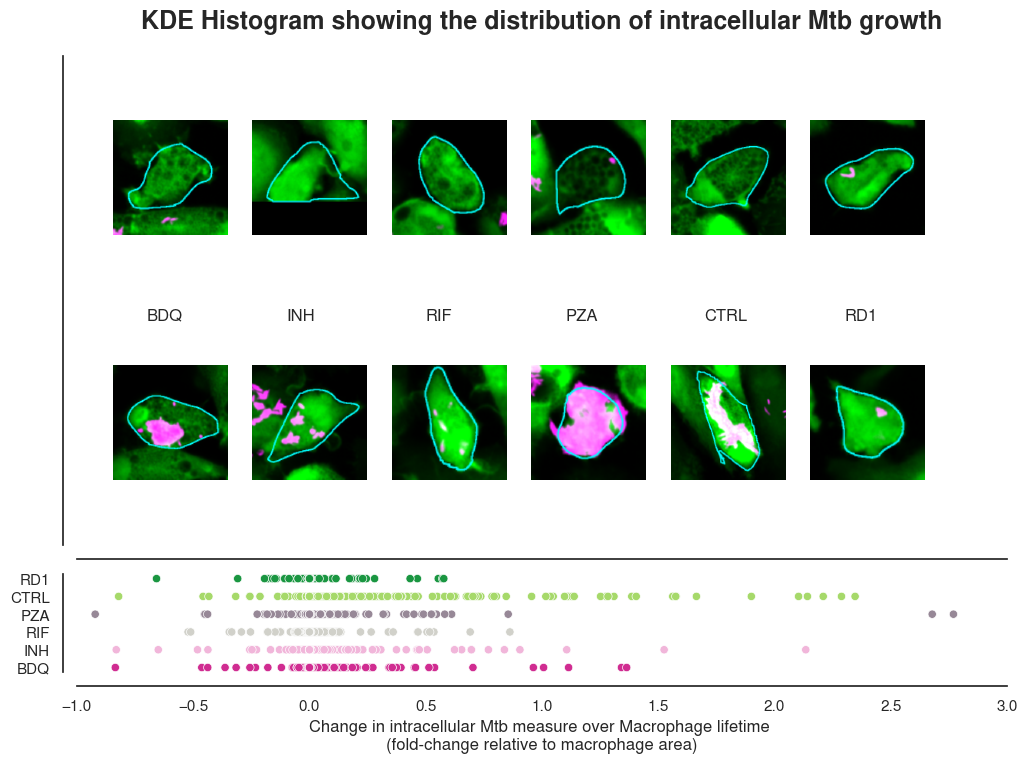

In [690]:
sns.set(font='Nimbus Sans', style = 'white')
sns.set_palette(expanded_piyg)

# Set the desired figure size and height ratios
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(12,8), gridspec_kw={'height_ratios': [5, 1]})
plt.rc('legend', loc="upper left", )

# iterate over 6 of the top outliers
# for n, (i, row_) in enumerate(df_max_dmtb.iterrows()):
## this way iterates over in the same order as the y axis
for n, sc in enumerate(reversed(df_delta_mtb['Strain/Compound'].unique().tolist())):
    # extract 
    row_ = df_max_dmtb[df_max_dmtb['Strain/Compound'] == sc]
    # load both images into memory
    img_t0 = io.imread(row_['glimpse_url_t0'].iloc[0])
    img_tn = io.imread(row_['glimpse_url_tn'].iloc[0])
    # Resize the images to 100x100 pixels
    img_t0 = transform.resize(img_t0, (150, 150), anti_aliasing=True)
    img_tn = transform.resize(img_tn, (150, 150), anti_aliasing=True)
    # add images
    imagebox = OffsetImage(img_t0, zoom = 0.55)
    # add coords for t0 images
    x = (n*0.6)-0.6#0.5#len(df_max_dmtb)-(n*0.8)-1.5
    y = 3#5.2
    coords = x, y
    ab = AnnotationBbox(imagebox, xy=coords, frameon = False)
    ax1.add_artist(ab)
    imagebox = OffsetImage(img_tn, zoom = 0.55)
    # add coords for tn images
    y = y - 2
    coords = x, y
    ab = AnnotationBbox(imagebox, xy=coords, frameon = False)
    ax1.add_artist(ab)
    # add labels
    ax1.text(x = coords[0]-0.1, y = y+0.84, s = row_['Compound/Strain'].iloc[0])

# Plot the scatter plot on ax2
scatter_plot = sns.scatterplot(data=df_delta_mtb, x='dMtb', y='Compound/Strain', hue='Compound/Strain', ax=ax2, legend=False)

# Remove y-axis labels for ax2
ax2.set_ylabel('')
# Remove y-axis labels for ax1
ax1.set_ylabel('')
ax1.set_yticklabels([])

# Set x-axis limits
# ax1.set_xlim(-1.05, 5)
ax1.set_xlim(-1, 3)
ax1.set_ylim(0,4)

# # set vertical line at origin
# ax1.vlines(x = 0, ymin = 0, ymax = kde_plot.dataLim.height*1.1, 
#            linestyles='dashed', color='black', linewidth = 0.5)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.1)
    
# ax1.text(x =4.88, y = 4.57, s = 'Initial measurement', rotation = -90, fontsize = 9)
# ax1.text(x =4.88, y = 2.8, s = 'Final measurement', rotation = -90, fontsize = 9)

# ax1.text(x=0.13, y=2.5, s='Single-cell measurements are shown below, whilst images of the greatest ΔMtb outliers are shown above', 
#         fontsize=9)

ax2.set_xlabel('Change in intracellular Mtb measure over Macrophage lifetime \n(fold-change relative to macrophage area)')
# Remove spines and trim
sns.despine(offset=10, )
# set title
title_text = 'KDE Histogram showing the distribution of intracellular Mtb growth'
title = ax1.set_title(title_text, y=1.04)
# title.set_text(title_text)
title.set_fontsize(18)
title.set_fontweight('heavy')
#save fig
# plt.savefig(os.path.join(output_dir, 'KDE_dMtb_sc_eg.pdf'), transparent = True, 
#             dpi = 314, bbox_inches = 'tight')

# Display the plot
plt.show()

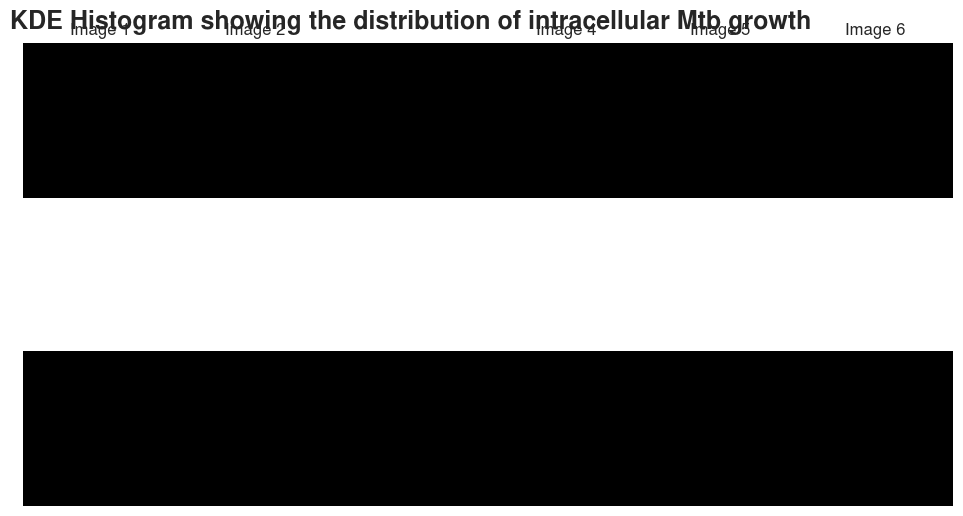

In [668]:
import matplotlib.pyplot as plt
import numpy as np

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(12, 8), sharex=True)

# Remove spacing between subplots
plt.subplots_adjust(wspace=0, hspace=0)

# Iterate over each axis and display images
for i, ax in enumerate(axes.flat):
    # Create an empty placeholder image
    img = np.zeros((100, 100, 3))  # Change the dimensions according to your image size
    
    # Display the image on the subplot
    ax.imshow(img)
    
    # Remove ticks and labels
    ax.axis('off')

# Set x-axis label for the bottom row of subplots
axes[-1, 2].set_xlabel('Change in intracellular Mtb measure over Macrophage lifetime \n(fold-change relative to macrophage area)')

# Set titles for the subplots
for i in range(6):
    axes[0, i].set_title(f'Image {i+1}')

# Set the main title
title_text = 'KDE Histogram showing the distribution of intracellular Mtb growth'
title = axes[0, 2].set_title(title_text, y=1.04)
title.set_fontsize(18)
title.set_fontweight('heavy')

# Remove spines and trim
for ax in axes.flat:
    sns.despine(ax=ax, offset=10)

# Save the figure if needed
# plt.savefig(os.path.join(output_dir, 'placeholder_images.png'), transparent=True, dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


In [626]:
output_dir

'/mnt/DATA/macrohet/results/preliminary_sc_measures/sc_graphs/dmtb_all_conditions'

# Change the shape 

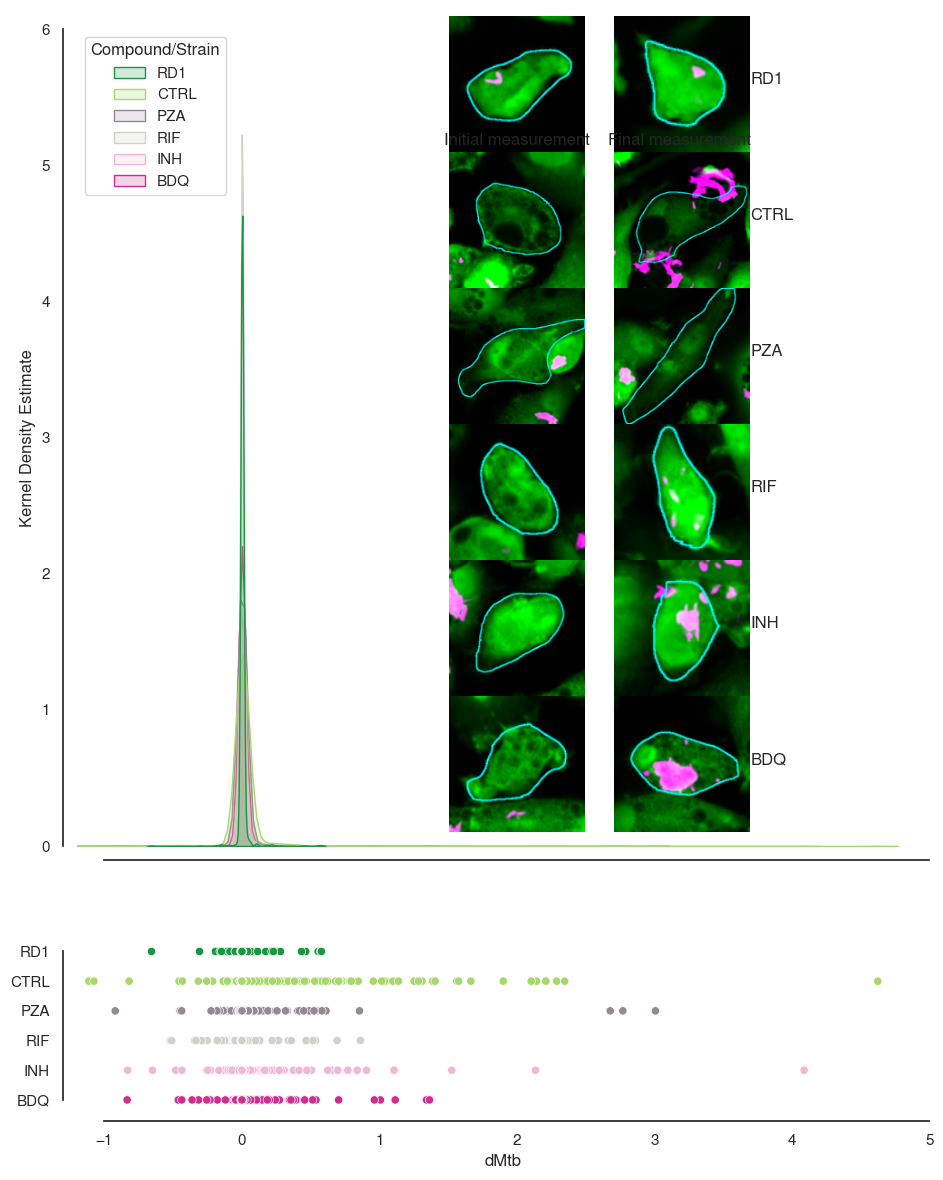

In [450]:
# Set the desired figure size and height ratios
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(11,14), gridspec_kw={'height_ratios': [5, 1]})
plt.rc('legend', loc="upper left", )

# Plot the KDE plot on ax1
kde_plot = sns.kdeplot(data=df_delta_mtb, x='dMtb', hue='Compound/Strain', ax=ax1, linewidth = 1, alpha = 0.2, fill = True
                      )

# Plot the scatter plot on ax2
scatter_plot = sns.scatterplot(data=df_delta_mtb, x='dMtb', y='Compound/Strain', hue='Compound/Strain', ax=ax2, legend=False)

# Remove y-axis labels for ax2
ax2.set_ylabel('')
# Remove y-axis labels for ax1
ax1.set_ylabel('Kernel Density Estimate')

# Set x-axis limits
ax1.set_xlim(-1.2, 5)
ax1.set_ylim(0,6)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.2)

# Remove spines and trim
sns.despine(offset=10, trim=True)

# iterate over 6 of the top outliers
# for n, (i, row_) in enumerate(df_max_dmtb.iterrows()):
## this way iterates over in the same order as the y axis
for n, sc in enumerate(df_delta_mtb['Strain/Compound'].unique().tolist()):
    # extract 
    row_ = df_max_dmtb[df_max_dmtb['Strain/Compound'] == sc]
    # load both images into memory
    img_t0 = io.imread(row_['glimpse_url_t0'].iloc[0])
    img_tn = io.imread(row_['glimpse_url_tn'].iloc[0])
    # Resize the images to 100x100 pixels
    img_t0 = transform.resize(img_t0, (150, 150), anti_aliasing=True)
    img_tn = transform.resize(img_tn, (150, 150), anti_aliasing=True)
    # add images
    imagebox = OffsetImage(img_t0, zoom = 0.65)
    coords = 2, len(df_max_dmtb)-n-0.4
    ab = AnnotationBbox(imagebox, xy=coords, frameon = False, )
    ax1.add_artist(ab)
    imagebox = OffsetImage(img_tn, zoom = 0.65)
    coords = 3.2, len(df_max_dmtb)-n-0.4
    ab = AnnotationBbox(imagebox, xy=coords, frameon = False, )
    ax1.add_artist(ab)
    # add labels
    ax1.text(x = coords[0]+0.5, y = coords[1], s = row_['Compound/Strain'].iloc[0])
    
ax1.text(x = 1.47, y = 5.15, s = 'Initial measurement')
ax1.text(x = 2.66, y = 5.15, s = 'Final measurement')
# Display the plot
plt.show()


# Creating scatter from one data source

Cannot currently link image URLs to segregated datasources...

In [156]:
from bokeh.models import HoverTool
from bokeh.plotting import figure, show, output_file, ColumnDataSource, output_notebook
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral6
from bokeh.models import WheelZoomTool
from bokeh.plotting import save
from bokeh.models import Label
from bokeh.models import LogScale
from bokeh.models import NumeralTickFormatter

output_notebook()


from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.layouts import column
from bokeh.layouts import gridplot
from bokeh.models import Range1d


output_notebook()

Loading BokehJS ...

Loading BokehJS ...

# 3 plots showing diff conditions

In [ ]:
from bokeh.layouts import gridplot
from scipy.stats import gaussian_kde

# Create the upper plot
p1 = figure(height=400, 
            width=450, 
            title='Histograms showing the distribution of \nthe change in intracellular Mtb (ΔMtb)', 
            y_axis_label='Frequency',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom')
p1.toolbar.active_scroll = p1.select_one(WheelZoomTool)
p1.x_range = Range1d(-0.4, 0.4)
# Customize y-axis ticker
p1.xaxis.visible = False  # Remove x-axis

# Create the lower plot
p2 = figure(height=200, 
            width=450, 
            x_axis_label='ΔMtb \n(fold-change relative to area)',
            y_axis_label='Outlier browser \n(1 S.D. from mean)',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom', 
            x_range=p1.x_range)

p2.yaxis.ticker = []  # Remove y-axis ticks
p2.yaxis.formatter = NumeralTickFormatter(format="0")  # Format tick labels

p2.toolbar.active_scroll = p2.select_one(WheelZoomTool)

# Create the hover tool
hover = HoverTool(
    tooltips=
    """ <div>
        <div style="position: relative; display: inline-block;">
            <img
                src="@glimpse_url_t0" height="120" alt="@glimpse_url_t0" width="120"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            >
            <div style="position: absolute; bottom: 5px; right: 5px; background-color: lightgrey; padding: 5px;">
                <span style="font-size: 12px; color: black;">t = 0</span>
            </div>
            </img>
        </div>
        <div style="position: relative; display: inline-block;">
            <img
                src="@glimpse_url_tn" height="120" alt="@glimpse_url_tn" width="120"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            >
            <div style="position: absolute; bottom: 5px; right: 5px; background-color: lightgrey; padding: 5px;">
                <span style="font-size: 12px; color: black;">t = final</span>
            </div>
            </img>
        </div>
        <div>
             <span style="font-size: 17px; font-weight: bold; color: black;">Cell ID: @cell_ID</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">ΔMtb: @x</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Strain: @strain</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Compound: @compound</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Concentration: @concentration</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Tech. replicate: @tech_rep</span>
         </div>
    </div>
""")

p2.add_tools(hover)  # Add the instance of HoverTool

outliers = list()
for index, condition in df_delta_mtb.groupby(['Strain', 'Compound', 'Concentration']).size().reset_index().rename(columns={0: 'count'}).iterrows():
    # only ec50
    if condition['Concentration'] != 'EC50':
        continue
    strain = condition['Strain']
    compound = condition['Compound']
    concentration = condition['Concentration']
    label = f'{strain}, {compound}, {concentration}'
    subset_df = df_delta_mtb[(df_delta_mtb['Strain'] == strain)
                             & (df_delta_mtb['Compound'] == compound)
                             & (df_delta_mtb['Concentration'] == concentration)
#                              & (df_delta_mtb['Technical replicate'] == 1)
                            ]
    data = subset_df['dMtb'].dropna()  # Remove NA values, if any
    kde = gaussian_kde(data)
    x = np.linspace(data.min(), data.max(), 100)
    kde_values = kde(x)

    source = ColumnDataSource(data=dict(x=x, kde_values=kde_values))

    # Create a quad glyph for the histogram in the upper plot
    p1.varea(x='x', y1=0, y2='kde_values',
             source=source, 
             fill_color=expanded_piyg_dict[compound], 
             alpha=0.6,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    p1.line(x='x', y='kde_values',
             source=source, 
             line_color=expanded_piyg_dict[compound], 
             line_width = 3, 
             alpha=1,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    
    # create a separate outlier df for below plot
    # Calculate the mean and standard deviation of dMtb
    mean = subset_df['dMtb'].mean()
    std = subset_df['dMtb'].std()

    # Define a threshold to determine outliers (e.g., 2 standard deviations from the mean)
    threshold = 1 * std

    # Filter out the non outliers from subset_df
    outlier_df = subset_df[abs(subset_df['dMtb'] - mean) >= threshold]
    outliers.append(outlier_df)
    
    # append url to df 
    for index, row_ in outlier_df.iterrows():
        unique_ID = row_['Unique ID']
        cell_ID, row, column = unique_ID.split('.') 
        t0 = row_['Time (hours)']
        outlier_df.at[index, 'glimpse_url_t0'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{t0}.png'
        outlier_df.at[index, 'glimpse_url_tn'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{-1}.png'

    # Create scatter plots for the lower plot
    source = ColumnDataSource(
            name=label,
            data=dict(
            x=outlier_df['dMtb'],
            y=outlier_df['Acquisition ID'].apply(lambda x: x[-1]),
            glimpse_url_t0=outlier_df['glimpse_url_t0'],
            glimpse_url_tn=outlier_df['glimpse_url_tn'], 
            dMtb=outlier_df['dMtb'], 
            cell_ID=outlier_df['Cell ID'], 
            strain=outlier_df['Strain'],
            compound=outlier_df['Compound'],
            concentration=outlier_df['Concentration'],
            tech_rep=outlier_df['Technical replicate']
        ))
    p2.scatter('x', 'y', 
               source=source,
               color=expanded_piyg_dict[compound], 
               alpha=0.9, 
               size=20,
               line_color='black',  # Set the color of the outline
               line_width=1,  # Set the width of the outline
               muted_color=expanded_piyg_dict[compound], 
               muted_alpha=0.1,
#                legend_label=label
              )
    p2.y_range.start = outlier_df['Acquisition ID'].apply(lambda x: x[-1]).min()-2  # Set the lower limit of the y-axis
    p2.y_range.end = outlier_df['Acquisition ID'].apply(lambda x: x[-1]).max()+3

# Set the legend location for the upper plot
p1.legend.location = "top_left"

# Uncomment the following line to set the legend location for the lower plot
# p2.legend.location = "top_left"

# Set the click_policy to "mute" for the legend in the upper plot
p1.legend.click_policy = "mute"
# Uncomment the following line to set the click_policy to "mute" for the legend in the lower plot
# p2.legend.click_policy = "mute"

# Create the upper plot
p3 = figure(height=400, 
            width=450, 
#             title='Histogram showing the distribution of the change in intracellular Mtb (ΔMtb)', 
            y_axis_label='Frequency',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom')
p3.toolbar.active_scroll = p3.select_one(WheelZoomTool)
p3.x_range = Range1d(-0.4, 0.4)

# Customize y-axis ticker
p3.xaxis.visible = False  # Remove x-axis

# Create the lower plot
p4 = figure(height=200, 
            width=450, 
            x_axis_label='ΔMtb \n(fold-change relative to area)',
            y_axis_label='Outlier browser \n(1 S.D. from mean)',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom', 
            x_range=p3.x_range)

p4.yaxis.ticker = []  # Remove y-axis ticks
p4.yaxis.formatter = NumeralTickFormatter(format="0")  # Format tick labels

p4.toolbar.active_scroll = p4.select_one(WheelZoomTool)

p4.add_tools(hover)  # Add the instance of HoverTool (no need to repeat)


for index, condition in df_delta_mtb.groupby(['Strain', 'Compound', 'Concentration']).size().reset_index().rename(columns={0: 'count'}).iterrows():
    # only ec99
    if condition['Concentration'] != 'EC99':
        continue
    strain = condition['Strain']
    compound = condition['Compound']
    concentration = condition['Concentration']
    label = f'{strain}, {compound}, {concentration}'
    subset_df = df_delta_mtb[(df_delta_mtb['Strain'] == strain)
                             & (df_delta_mtb['Compound'] == compound)
                             & (df_delta_mtb['Concentration'] == concentration)
#                              & (df_delta_mtb['Technical replicate'] == 1)
                            ]
    data = subset_df['dMtb'].dropna()  # Remove NA values, if any
    kde = gaussian_kde(data)
    x = np.linspace(data.min(), data.max(), 100)
    kde_values = kde(x)

    source = ColumnDataSource(data=dict(x=x, kde_values=kde_values))

    # Create a quad glyph for the histogram in the upper plot
    p3.varea(x='x', y1=0, y2='kde_values',
             source=source, 
             fill_color=expanded_piyg_dict[compound], 
             alpha=0.6,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    p3.line(x='x', y='kde_values',
             source=source, 
             line_color=expanded_piyg_dict[compound], 
             line_width = 3,
             alpha=1,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    
    
    # create a separate outlier df for below plot
    # Calculate the mean and standard deviation of dMtb
    mean = subset_df['dMtb'].mean()
    std = subset_df['dMtb'].std()

    # Define a threshold to determine outliers (e.g., 2 standard deviations from the mean)
    threshold = 1 * std

    # Filter out the non outliers from subset_df
    outlier_df = subset_df[abs(subset_df['dMtb'] - mean) >= threshold]
    outliers.append(outlier_df)
    
    # append url to df 
    for index, row_ in outlier_df.iterrows():
        unique_ID = row_['Unique ID']
        cell_ID, row, column = unique_ID.split('.') 
        t0 = row_['Time (hours)']
        outlier_df.at[index, 'glimpse_url_t0'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{t0}.png'
        outlier_df.at[index, 'glimpse_url_tn'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{-1}.png'

    # Create scatter plots for the lower plot
    source = ColumnDataSource(
            name=label,
            data=dict(
            x=outlier_df['dMtb'],
            y=outlier_df['Acquisition ID'].apply(lambda x: x[-1]),
            glimpse_url_t0=outlier_df['glimpse_url_t0'],
            glimpse_url_tn=outlier_df['glimpse_url_tn'], 
            dMtb=outlier_df['dMtb'], 
            cell_ID=outlier_df['Cell ID'], 
            strain=outlier_df['Strain'],
            compound=outlier_df['Compound'],
            concentration=outlier_df['Concentration'],
            tech_rep=outlier_df['Technical replicate']
        ))
    p4.scatter('x', 'y', 
               source=source,
               color=expanded_piyg_dict[compound], 
               alpha=0.9, 
               size=20,
               line_color='black',  # Set the color of the outline
               line_width=1,  # Set the width of the outline
               muted_color=expanded_piyg_dict[compound], 
               muted_alpha=0.1,
#                legend_label=label
              )
        
    p4.y_range.start = outlier_df['Acquisition ID'].apply(lambda x: x[-1]).min()-2  # Set the lower limit of the y-axis
    p4.y_range.end = outlier_df['Acquisition ID'].apply(lambda x: x[-1]).max()+3

# Set the legend location for the upper plot
p3.legend.location = "top_left"

# Uncomment the following line to set the legend location for the lower plot
# p2.legend.location = "top_left"

# Set the click_policy to "mute" for the legend in the upper plot
p3.legend.click_policy = "mute"
# Uncomment the following line to set the click_policy to "mute" for the legend in the lower plot
# p2.legend.click_policy = "mute"

# Create the upper plot
p5 = figure(height=400, 
            width=450, 
            title='Control experiments', 
            y_axis_label='Frequency',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom')
p5.toolbar.active_scroll = p5.select_one(WheelZoomTool)
p5.x_range = Range1d(-0.4, 0.4)

# Customize y-axis ticker
p5.xaxis.visible = False  # Remove x-axis

# Create the lower plot
p6 = figure(height=200, 
            width=450, 
            x_axis_label='ΔMtb \n(fold-change relative to area)',
            y_axis_label='Outlier browser \n(1 S.D. from mean)',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom', 
            x_range=p5.x_range)

p6.yaxis.ticker = []  # Remove y-axis ticks
p6.yaxis.formatter = NumeralTickFormatter(format="0")  # Format tick labels

p6.toolbar.active_scroll = p6.select_one(WheelZoomTool)

p6.add_tools(hover)  # Add the instance of HoverTool (no need to repeat)

for index, condition in df_delta_mtb.groupby(['Strain', 'Compound', 'Concentration']).size().reset_index().rename(columns={0: 'count'}).iterrows():
    # only ec99
    if condition['Concentration'] != 'EC0':
        continue
    strain = condition['Strain']
    compound = condition['Compound']
    concentration = condition['Concentration']
    label = f'{strain}, {compound}, {concentration}'
    subset_df = df_delta_mtb[(df_delta_mtb['Strain'] == strain)
                             & (df_delta_mtb['Compound'] == compound)
                             & (df_delta_mtb['Concentration'] == concentration)
#                              & (df_delta_mtb['Technical replicate'] == 1)
                            ]
    data = subset_df['dMtb'].dropna()  # Remove NA values, if any
    kde = gaussian_kde(data)
    x = np.linspace(data.min(), data.max(), 100)
    kde_values = kde(x)

    source = ColumnDataSource(data=dict(x=x, kde_values=kde_values))

    # Create a quad glyph for the histogram in the upper plot
    p5.varea(x='x', y1=0, y2='kde_values',
             source=source, 
             fill_color = expanded_piyg[0] if strain == 'WT' else expanded_piyg[-1],
             alpha=0.6,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    p5.line(x='x', y='kde_values',
             source=source, 
             line_color = expanded_piyg[0] if strain == 'WT' else expanded_piyg[-1], 
             line_width = 1,
             line_dash = 'dashed',
             alpha=1,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    
    # create a separate outlier df for below plot
    # Calculate the mean and standard deviation of dMtb
    mean = subset_df['dMtb'].mean()
    std = subset_df['dMtb'].std()

    # Define a threshold to determine outliers (e.g., 2 standard deviations from the mean)
    threshold = 1 * std

    # Filter out the non outliers from subset_df
    outlier_df = subset_df[abs(subset_df['dMtb'] - mean) >= threshold]
    outliers.append(outlier_df)
    
    # append url to df 
    for index, row_ in outlier_df.iterrows():
        unique_ID = row_['Unique ID']
        cell_ID, row, column = unique_ID.split('.') 
        t0 = row_['Time (hours)']
        outlier_df.at[index, 'glimpse_url_t0'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{t0}.png'
        outlier_df.at[index, 'glimpse_url_tn'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{-1}.png'

    # Create scatter plots for the lower plot
    source = ColumnDataSource(
            name=label,
            data=dict(
            x=outlier_df['dMtb'],
            y=outlier_df['Acquisition ID'].apply(lambda x: x[-1]),
            glimpse_url_t0=outlier_df['glimpse_url_t0'],
            glimpse_url_tn=outlier_df['glimpse_url_tn'], 
            dMtb=outlier_df['dMtb'], 
            cell_ID=outlier_df['Cell ID'], 
            strain=outlier_df['Strain'],
            compound=outlier_df['Compound'],
            concentration=outlier_df['Concentration'],
            tech_rep=outlier_df['Technical replicate']
        ))
    p6.scatter('x', 'y', 
               source=source,
               fill_color = expanded_piyg[0] if strain == 'WT' else expanded_piyg[-1],
               alpha=0.9, 
               size=20,
               line_color='black',  # Set the color of the outline
               line_width=1,  # Set the width of the outline
               muted_color=expanded_piyg_dict[compound], 
               muted_alpha=0.1,
#                legend_label=label
              )
    p6.y_range.start = outlier_df['Acquisition ID'].apply(lambda x: x[-1]).min()-2  # Set the lower limit of the y-axis
    p6.y_range.end = outlier_df['Acquisition ID'].apply(lambda x: x[-1]).max()+1

# Set the legend location for the upper plot
p5.legend.location = "top_left"

# Uncomment the following line to set the legend location for the lower plot
# p2.legend.location = "top_left"

# Set the click_policy to "mute" for the legend in the upper plot
p5.legend.click_policy = "mute"
# Uncomment the following line to set the click_policy to "mute" for the legend in the lower plot
# p2.legend.click_policy = "mute"

# Create a grid plot with both plots repeated on the right-hand side
p = gridplot([[p1, p3, p5], [p2, p4, p6]])

# output_file(os.path.join(output_dir, "dMtb_kde.html"),title="dMtb")

show(p)


In [157]:
from bokeh.layouts import gridplot
from scipy.stats import gaussian_kde

# Create the upper plot
p1 = figure(height=400, 
            width=450, 
            title='Histograms showing the distribution of \nthe change in intracellular Mtb (ΔMtb)', 
            y_axis_label='Frequency',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom')
p1.toolbar.active_scroll = p1.select_one(WheelZoomTool)
p1.x_range = Range1d(-0.4, 0.4)
# Customize y-axis ticker
p1.xaxis.visible = False  # Remove x-axis

# Create the lower plot
p2 = figure(height=200, 
            width=450, 
            x_axis_label='ΔMtb \n(fold-change relative to area)',
            y_axis_label='Outlier browser \n(1 S.D. from mean)',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom', 
            x_range=p1.x_range)

p2.yaxis.ticker = []  # Remove y-axis ticks
p2.yaxis.formatter = NumeralTickFormatter(format="0")  # Format tick labels

p2.toolbar.active_scroll = p2.select_one(WheelZoomTool)

# Create the hover tool
hover = HoverTool(
    tooltips=
    """ <div>
        <div style="position: relative; display: inline-block;">
            <img
                src="@glimpse_url_t0" height="120" alt="@glimpse_url_t0" width="120"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            >
            <div style="position: absolute; bottom: 5px; right: 5px; background-color: lightgrey; padding: 5px;">
                <span style="font-size: 12px; color: black;">t = 0</span>
            </div>
            </img>
        </div>
        <div style="position: relative; display: inline-block;">
            <img
                src="@glimpse_url_tn" height="120" alt="@glimpse_url_tn" width="120"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            >
            <div style="position: absolute; bottom: 5px; right: 5px; background-color: lightgrey; padding: 5px;">
                <span style="font-size: 12px; color: black;">t = final</span>
            </div>
            </img>
        </div>
        <div>
             <span style="font-size: 17px; font-weight: bold; color: black;">Cell ID: @cell_ID</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">ΔMtb: @x</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Strain: @strain</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Compound: @compound</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Concentration: @concentration</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Tech. replicate: @tech_rep</span>
         </div>
    </div>
""")

p2.add_tools(hover)  # Add the instance of HoverTool

outliers = list()
for index, condition in df_delta_mtb.groupby(['Strain', 'Compound', 'Concentration']).size().reset_index().rename(columns={0: 'count'}).iterrows():
    # only ec50
    if condition['Concentration'] != 'EC50':
        continue
    strain = condition['Strain']
    compound = condition['Compound']
    concentration = condition['Concentration']
    label = f'{strain}, {compound}, {concentration}'
    subset_df = df_delta_mtb[(df_delta_mtb['Strain'] == strain)
                             & (df_delta_mtb['Compound'] == compound)
                             & (df_delta_mtb['Concentration'] == concentration)
#                              & (df_delta_mtb['Technical replicate'] == 1)
                            ]
    data = subset_df['dMtb'].dropna()  # Remove NA values, if any
    kde = gaussian_kde(data)
    x = np.linspace(data.min(), data.max(), 100)
    kde_values = kde(x)

    source = ColumnDataSource(data=dict(x=x, kde_values=kde_values))

    # Create a quad glyph for the histogram in the upper plot
    p1.varea(x='x', y1=0, y2='kde_values',
             source=source, 
             fill_color=expanded_piyg_dict[compound], 
             alpha=0.6,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    p1.line(x='x', y='kde_values',
             source=source, 
             line_color=expanded_piyg_dict[compound], 
             line_width = 3, 
             alpha=1,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    
    # create a separate outlier df for below plot
    # Calculate the mean and standard deviation of dMtb
    mean = subset_df['dMtb'].mean()
    std = subset_df['dMtb'].std()

    # Define a threshold to determine outliers (e.g., 2 standard deviations from the mean)
    threshold = 1 * std

    # Filter out the non outliers from subset_df
    outlier_df = subset_df[abs(subset_df['dMtb'] - mean) >= threshold]
    outliers.append(outlier_df)
    
    # append url to df 
    for index, row_ in outlier_df.iterrows():
        unique_ID = row_['Unique ID']
        cell_ID, row, column = unique_ID.split('.') 
        t0 = row_['Time (hours)']
        outlier_df.at[index, 'glimpse_url_t0'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{t0}.png'
        outlier_df.at[index, 'glimpse_url_tn'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{-1}.png'

    # Create scatter plots for the lower plot
    source = ColumnDataSource(
            name=label,
            data=dict(
            x=outlier_df['dMtb'],
            y=outlier_df['Acquisition ID'].apply(lambda x: x[-1]),
            glimpse_url_t0=outlier_df['glimpse_url_t0'],
            glimpse_url_tn=outlier_df['glimpse_url_tn'], 
            dMtb=outlier_df['dMtb'], 
            cell_ID=outlier_df['Cell ID'], 
            strain=outlier_df['Strain'],
            compound=outlier_df['Compound'],
            concentration=outlier_df['Concentration'],
            tech_rep=outlier_df['Technical replicate']
        ))
    p2.scatter('x', 'y', 
               source=source,
               color=expanded_piyg_dict[compound], 
               alpha=0.9, 
               size=20,
               line_color='black',  # Set the color of the outline
               line_width=1,  # Set the width of the outline
               muted_color=expanded_piyg_dict[compound], 
               muted_alpha=0.1,
#                legend_label=label
              )
    p2.y_range.start = outlier_df['Acquisition ID'].apply(lambda x: x[-1]).min()-2  # Set the lower limit of the y-axis
    p2.y_range.end = outlier_df['Acquisition ID'].apply(lambda x: x[-1]).max()+3

# Set the legend location for the upper plot
p1.legend.location = "top_left"

# Uncomment the following line to set the legend location for the lower plot
# p2.legend.location = "top_left"

# Set the click_policy to "mute" for the legend in the upper plot
p1.legend.click_policy = "mute"
# Uncomment the following line to set the click_policy to "mute" for the legend in the lower plot
# p2.legend.click_policy = "mute"

# Create the upper plot
p3 = figure(height=400, 
            width=450, 
#             title='Histogram showing the distribution of the change in intracellular Mtb (ΔMtb)', 
            y_axis_label='Frequency',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom')
p3.toolbar.active_scroll = p3.select_one(WheelZoomTool)
p3.x_range = Range1d(-0.4, 0.4)

# Customize y-axis ticker
p3.xaxis.visible = False  # Remove x-axis

# Create the lower plot
p4 = figure(height=200, 
            width=450, 
            x_axis_label='ΔMtb \n(fold-change relative to area)',
            y_axis_label='Outlier browser \n(1 S.D. from mean)',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom', 
            x_range=p3.x_range)

p4.yaxis.ticker = []  # Remove y-axis ticks
p4.yaxis.formatter = NumeralTickFormatter(format="0")  # Format tick labels

p4.toolbar.active_scroll = p4.select_one(WheelZoomTool)

p4.add_tools(hover)  # Add the instance of HoverTool (no need to repeat)


for index, condition in df_delta_mtb.groupby(['Strain', 'Compound', 'Concentration']).size().reset_index().rename(columns={0: 'count'}).iterrows():
    # only ec99
    if condition['Concentration'] != 'EC99':
        continue
    strain = condition['Strain']
    compound = condition['Compound']
    concentration = condition['Concentration']
    label = f'{strain}, {compound}, {concentration}'
    subset_df = df_delta_mtb[(df_delta_mtb['Strain'] == strain)
                             & (df_delta_mtb['Compound'] == compound)
                             & (df_delta_mtb['Concentration'] == concentration)
#                              & (df_delta_mtb['Technical replicate'] == 1)
                            ]
    data = subset_df['dMtb'].dropna()  # Remove NA values, if any
    kde = gaussian_kde(data)
    x = np.linspace(data.min(), data.max(), 100)
    kde_values = kde(x)

    source = ColumnDataSource(data=dict(x=x, kde_values=kde_values))

    # Create a quad glyph for the histogram in the upper plot
    p3.varea(x='x', y1=0, y2='kde_values',
             source=source, 
             fill_color=expanded_piyg_dict[compound], 
             alpha=0.6,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    p3.line(x='x', y='kde_values',
             source=source, 
             line_color=expanded_piyg_dict[compound], 
             line_width = 3,
             alpha=1,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    
    
    # create a separate outlier df for below plot
    # Calculate the mean and standard deviation of dMtb
    mean = subset_df['dMtb'].mean()
    std = subset_df['dMtb'].std()

    # Define a threshold to determine outliers (e.g., 2 standard deviations from the mean)
    threshold = 1 * std

    # Filter out the non outliers from subset_df
    outlier_df = subset_df[abs(subset_df['dMtb'] - mean) >= threshold]
    outliers.append(outlier_df)
    
    # append url to df 
    for index, row_ in outlier_df.iterrows():
        unique_ID = row_['Unique ID']
        cell_ID, row, column = unique_ID.split('.') 
        t0 = row_['Time (hours)']
        outlier_df.at[index, 'glimpse_url_t0'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{t0}.png'
        outlier_df.at[index, 'glimpse_url_tn'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{-1}.png'

    # Create scatter plots for the lower plot
    source = ColumnDataSource(
            name=label,
            data=dict(
            x=outlier_df['dMtb'],
            y=outlier_df['Acquisition ID'].apply(lambda x: x[-1]),
            glimpse_url_t0=outlier_df['glimpse_url_t0'],
            glimpse_url_tn=outlier_df['glimpse_url_tn'], 
            dMtb=outlier_df['dMtb'], 
            cell_ID=outlier_df['Cell ID'], 
            strain=outlier_df['Strain'],
            compound=outlier_df['Compound'],
            concentration=outlier_df['Concentration'],
            tech_rep=outlier_df['Technical replicate']
        ))
    p4.scatter('x', 'y', 
               source=source,
               color=expanded_piyg_dict[compound], 
               alpha=0.9, 
               size=20,
               line_color='black',  # Set the color of the outline
               line_width=1,  # Set the width of the outline
               muted_color=expanded_piyg_dict[compound], 
               muted_alpha=0.1,
#                legend_label=label
              )
        
    p4.y_range.start = outlier_df['Acquisition ID'].apply(lambda x: x[-1]).min()-2  # Set the lower limit of the y-axis
    p4.y_range.end = outlier_df['Acquisition ID'].apply(lambda x: x[-1]).max()+3

# Set the legend location for the upper plot
p3.legend.location = "top_left"

# Uncomment the following line to set the legend location for the lower plot
# p2.legend.location = "top_left"

# Set the click_policy to "mute" for the legend in the upper plot
p3.legend.click_policy = "mute"
# Uncomment the following line to set the click_policy to "mute" for the legend in the lower plot
# p2.legend.click_policy = "mute"

# Create the upper plot
p5 = figure(height=400, 
            width=450, 
            title='Control experiments', 
            y_axis_label='Frequency',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom')
p5.toolbar.active_scroll = p5.select_one(WheelZoomTool)
p5.x_range = Range1d(-0.4, 0.4)

# Customize y-axis ticker
p5.xaxis.visible = False  # Remove x-axis

# Create the lower plot
p6 = figure(height=200, 
            width=450, 
            x_axis_label='ΔMtb \n(fold-change relative to area)',
            y_axis_label='Outlier browser \n(1 S.D. from mean)',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom', 
            x_range=p5.x_range)

p6.yaxis.ticker = []  # Remove y-axis ticks
p6.yaxis.formatter = NumeralTickFormatter(format="0")  # Format tick labels

p6.toolbar.active_scroll = p6.select_one(WheelZoomTool)

p6.add_tools(hover)  # Add the instance of HoverTool (no need to repeat)

for index, condition in df_delta_mtb.groupby(['Strain', 'Compound', 'Concentration']).size().reset_index().rename(columns={0: 'count'}).iterrows():
    # only ec99
    if condition['Concentration'] != 'EC0':
        continue
    strain = condition['Strain']
    compound = condition['Compound']
    concentration = condition['Concentration']
    label = f'{strain}, {compound}, {concentration}'
    subset_df = df_delta_mtb[(df_delta_mtb['Strain'] == strain)
                             & (df_delta_mtb['Compound'] == compound)
                             & (df_delta_mtb['Concentration'] == concentration)
#                              & (df_delta_mtb['Technical replicate'] == 1)
                            ]
    data = subset_df['dMtb'].dropna()  # Remove NA values, if any
    kde = gaussian_kde(data)
    x = np.linspace(data.min(), data.max(), 100)
    kde_values = kde(x)

    source = ColumnDataSource(data=dict(x=x, kde_values=kde_values))

    # Create a quad glyph for the histogram in the upper plot
    p5.varea(x='x', y1=0, y2='kde_values',
             source=source, 
             fill_color = expanded_piyg[0] if strain == 'WT' else expanded_piyg[-1],
             alpha=0.6,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    p5.line(x='x', y='kde_values',
             source=source, 
             line_color = expanded_piyg[0] if strain == 'WT' else expanded_piyg[-1], 
             line_width = 1,
             line_dash = 'dashed',
             alpha=1,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    
    # create a separate outlier df for below plot
    # Calculate the mean and standard deviation of dMtb
    mean = subset_df['dMtb'].mean()
    std = subset_df['dMtb'].std()

    # Define a threshold to determine outliers (e.g., 2 standard deviations from the mean)
    threshold = 1 * std

    # Filter out the non outliers from subset_df
    outlier_df = subset_df[abs(subset_df['dMtb'] - mean) >= threshold]
    outliers.append(outlier_df)
    
    # append url to df 
    for index, row_ in outlier_df.iterrows():
        unique_ID = row_['Unique ID']
        cell_ID, row, column = unique_ID.split('.') 
        t0 = row_['Time (hours)']
        outlier_df.at[index, 'glimpse_url_t0'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{t0}.png'
        outlier_df.at[index, 'glimpse_url_tn'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{-1}.png'

    # Create scatter plots for the lower plot
    source = ColumnDataSource(
            name=label,
            data=dict(
            x=outlier_df['dMtb'],
            y=outlier_df['Acquisition ID'].apply(lambda x: x[-1]),
            glimpse_url_t0=outlier_df['glimpse_url_t0'],
            glimpse_url_tn=outlier_df['glimpse_url_tn'], 
            dMtb=outlier_df['dMtb'], 
            cell_ID=outlier_df['Cell ID'], 
            strain=outlier_df['Strain'],
            compound=outlier_df['Compound'],
            concentration=outlier_df['Concentration'],
            tech_rep=outlier_df['Technical replicate']
        ))
    p6.scatter('x', 'y', 
               source=source,
               fill_color = expanded_piyg[0] if strain == 'WT' else expanded_piyg[-1],
               alpha=0.9, 
               size=20,
               line_color='black',  # Set the color of the outline
               line_width=1,  # Set the width of the outline
               muted_color=expanded_piyg_dict[compound], 
               muted_alpha=0.1,
#                legend_label=label
              )
    p6.y_range.start = outlier_df['Acquisition ID'].apply(lambda x: x[-1]).min()-2  # Set the lower limit of the y-axis
    p6.y_range.end = outlier_df['Acquisition ID'].apply(lambda x: x[-1]).max()+1

# Set the legend location for the upper plot
p5.legend.location = "top_left"

# Uncomment the following line to set the legend location for the lower plot
# p2.legend.location = "top_left"

# Set the click_policy to "mute" for the legend in the upper plot
p5.legend.click_policy = "mute"
# Uncomment the following line to set the click_policy to "mute" for the legend in the lower plot
# p2.legend.click_policy = "mute"

# Create a grid plot with both plots repeated on the right-hand side
p = gridplot([[p1, p3, p5], [p2, p4, p6]])

# output_file(os.path.join(output_dir, "dMtb_kde.html"),title="dMtb")

show(p)


In [49]:
outlier_df['Acquisition ID'].apply(lambda x: x[-1]).min()

4

In [727]:
outliers = pd.concat(outliers, ignore_index=True)
outliers

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Compound,Concentration,Cell ID,Acquisition ID,Unique ID,dMtb,Technical replicate,glimpse_url,glimpse_url_t0,glimpse_url_tn
0,0,539.885864,99.211456,2721.024756,500.025740,0.0,0.0,1.0,24629.0,367.672302,...,BDQ,EC50,421,"(3, 9)",421.3.9,0.244142,1,"https://macrohet.s3.eu-west-2.amazonaws.com/3,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
1,0,1074.527832,811.853455,5415.620273,4091.741411,0.0,0.0,1.0,19622.0,369.415039,...,BDQ,EC50,113,"(3, 9)",113.3.9,1.114547,1,"https://macrohet.s3.eu-west-2.amazonaws.com/3,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
2,0,1097.321167,847.022522,5530.498682,4268.993511,0.0,0.0,1.0,10637.0,375.349060,...,BDQ,EC50,26,"(3, 9)",26.3.9,0.254726,1,"https://macrohet.s3.eu-west-2.amazonaws.com/3,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
3,0,1039.033447,916.104431,5236.728574,4617.166333,1.0,1.0,1.0,19872.0,389.052826,...,BDQ,EC50,63,"(3, 9)",63.3.9,0.154472,1,"https://macrohet.s3.eu-west-2.amazonaws.com/3,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
4,0,771.073486,1052.282593,3886.210371,5303.504268,0.0,0.0,1.0,28811.0,361.714722,...,BDQ,EC50,275,"(3, 9)",275.3.9,0.160494,1,"https://macrohet.s3.eu-west-2.amazonaws.com/3,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,4,757.554932,170.470444,3818.076855,859.171036,1.0,1.0,1.0,13940.0,388.782074,...,CTRL,EC0,1075,"(6, 5)",1075.6.5,0.276201,2,"https://macrohet.s3.eu-west-2.amazonaws.com/6,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
311,6,122.582176,206.176346,617.814168,1039.128783,0.0,0.0,1.0,14622.0,382.337433,...,CTRL,EC0,1216,"(6, 5)",1216.6.5,0.258478,2,"https://macrohet.s3.eu-west-2.amazonaws.com/6,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
312,7,818.922974,438.001740,4127.371787,2207.528767,0.0,0.0,1.0,31789.0,345.671936,...,CTRL,EC0,1314,"(6, 5)",1314.6.5,1.900590,2,"https://macrohet.s3.eu-west-2.amazonaws.com/6,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
313,16,333.640533,118.059662,1681.548289,595.020696,0.0,0.0,1.0,52010.0,366.959137,...,CTRL,EC0,1894,"(6, 5)",1894.6.5,1.283940,2,"https://macrohet.s3.eu-west-2.amazonaws.com/6,...",https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...


In [3]:
import napari
from cellpose import models
from macrohet import dataio, tile
import numpy as np
import os

def view(img):
    return napari.Viewer().add_image(img)

from napari_animation import Animation
from tqdm.auto import tqdm

import btrack
import dask.array as da

from skimage.transform import rescale, resize, downscale_local_mean

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")
sns.set_palette("Spectral")

from macrohet import tools, visualise

### Load all metadata

Both the image metadata and the assay layout metadata

In [2]:
base_dir = '/mnt/DATA/macrohet/'
# base_dir = '/Volumes/lab-gutierrezm/home/users/dayn/macrohet/'
metadata_fn = os.path.join(base_dir, 'macrohet_images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [4]:
metadata_path = os.path.join(base_dir, 'macrohet_images/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

# Iteratively load all tracks

and append to a track_dict dictionary

In [5]:
tracks_dict = dict()
### iterate over all experimental conditions
for (row, column), info in tqdm(assay_layout.iterrows(), 
                                desc = 'Progress through positions',
                                total = len(assay_layout)):

    ### load tracks
    with btrack.io.HDF5FileHandler(os.path.join(base_dir, 
                                                f'labels/macrohet_seg_model/{row,column}.h5'), 
                                       'r', 
                                       obj_type='obj_type_1'
                                       ) as reader:
        tracks = reader.tracks
            
    ### append tracks to dictionary
    tracks_dict[(row, column)] = tracks

Progress through positions:   0%|          | 0/24 [00:00<?, ?it/s]

[INFO][2023/06/07 11:49:44 AM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 4).h5...
[INFO][2023/06/07 11:49:44 AM] Loading tracks/obj_type_1
[INFO][2023/06/07 11:49:44 AM] Loading LBEP/obj_type_1
[INFO][2023/06/07 11:49:44 AM] Loading objects/obj_type_1 (39878, 5) (39878 filtered: None)
[INFO][2023/06/07 11:49:45 AM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 4).h5
[INFO][2023/06/07 11:49:45 AM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5...
[INFO][2023/06/07 11:49:45 AM] Loading tracks/obj_type_1
[INFO][2023/06/07 11:49:45 AM] Loading LBEP/obj_type_1
[INFO][2023/06/07 11:49:45 AM] Loading objects/obj_type_1 (41424, 5) (41424 filtered: None)
[INFO][2023/06/07 11:49:46 AM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5
[INFO][2023/06/07 11:49:46 AM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 6).h5...
[INFO][2023/06/07 11:49:46 AM] Loading tracks/obj_type_1
[INFO]

[INFO][2023/06/07 11:50:02 AM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5
[INFO][2023/06/07 11:50:02 AM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 6).h5...
[INFO][2023/06/07 11:50:02 AM] Loading tracks/obj_type_1
[INFO][2023/06/07 11:50:02 AM] Loading LBEP/obj_type_1
[INFO][2023/06/07 11:50:02 AM] Loading objects/obj_type_1 (45688, 5) (45688 filtered: None)
[INFO][2023/06/07 11:50:03 AM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 6).h5
[INFO][2023/06/07 11:50:03 AM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5...
[INFO][2023/06/07 11:50:03 AM] Loading tracks/obj_type_1
[INFO][2023/06/07 11:50:03 AM] Loading LBEP/obj_type_1
[INFO][2023/06/07 11:50:03 AM] Loading objects/obj_type_1 (45214, 5) (45214 filtered: None)
[INFO][2023/06/07 11:50:05 AM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5
[INFO][2023/06/07 11:50:05 AM] Opening HDF file: /mnt/DATA/macrohe

# Compile all longer length tracks into dataframe

Add extra information such as the MSD of cells between frames

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import tools

def create_track_dictionary(track, info):
    """
    Create a dictionary of track information for a single track.
    
    Parameters:
    - track (dict): Track information dictionary
    - info (Series): Assay layout info for the track
    
    Returns:
    - dict: Dictionary containing track information
    """
    # Raw MTB values (interpolated)
    raw_mtb_values = pd.Series(track['mean_intensity'][:, 1]).interpolate(method='linear')
    
    # Raw GFP values (interpolated)
    raw_gfp = pd.Series(track['mean_intensity'][:, 0]).interpolate(method='linear')
    
    # Thresholded MTB values (interpolated)
    mtb_values = pd.Series(track['mean_intensity'][:, 2]).interpolate(method='linear')
    
    # Smoothed MTB signal using a rolling window of 4 with median values,
    # then backfilling missing values at the start
    mtb_smooth = np.array(mtb_values.rolling(window=4).median().interpolate(method='backfill'))
    
    # Interpolate other variables using appropriate methods
    minor_axis_length = pd.Series(track['minor_axis_length']).interpolate(method='linear')
    major_axis_length = pd.Series(track['major_axis_length']).interpolate(method='linear')
    
    # Interpolate infection status using a combination of approaches
    infection_status = pd.Series(track['Infected'])
    
    # If the first value is missing, assign it the closest infection value
    if pd.isnull(infection_status.iloc[0]):
        infection_status.iloc[0] = infection_status.iloc[infection_status.first_valid_index()]
    
    # Fill subsequent missing values with the previous value
    infection_status = infection_status.fillna(method='ffill')
    
    # Interpolate area based on linear method
    area = pd.Series(track['area']).interpolate(method='linear')
    
    # Compile single track dictionary of info
    d = {
        'Time (hours)': track['t'],                                      # Time (hours)
        'x': track['x'],                                                  # x
        'y': track['y'],                                                  # y
        'x scaled': [track['x'][i] * 5.04 for i, x in enumerate(track['x'])],    # x scaled
        'y scaled': [track['y'][i] * 5.04 for i, y in enumerate(track['y'])],    # y scaled
        'Infection status': track['Infected'],                            # Infection status
        'Initial infection status': track['Infected'][0],                # Initial infection status
        'Final infection status': track['Infected'][-1],                 # Final infection status
        'Area': track['area'],                                            # Area
        'Intracellular mean Mtb content': raw_mtb_values,                 # Intracellular mean Mtb content
        'Intracellular thresholded Mtb content': mtb_values,              # Intracellular thresholded Mtb content
        'Intracellular thresholded Mtb content smooth': mtb_smooth,       # Intracellular thresholded Mtb content smooth
        'Macroph. GFP expression': raw_gfp,                               # Macroph. GFP expression
        'delta Mtb raw': [np.array(mtb_values)[-1] - np.array(mtb_values)[0] for i in range(len(track))],   # delta Mtb raw
        'delta Mtb max raw': [(max(mtb_values) - min(mtb_values)) * (1 if np.argmax(mtb_values) > np.argmin(mtb_values) else -1) for i in range(len(track))],   # delta Mtb max raw
        'delta Mtb max smooth': [(max(mtb_smooth) - min(mtb_smooth)) * (1 if np.argmax(mtb_smooth) > np.argmin(mtb_smooth) else -1) for i in range(len(track))],   # delta Mtb max smooth
        'delta Mtb max fold-change': [max(mtb_smooth) / min(mtb_smooth[mtb_smooth > 0]) * (1 if np.argmax(mtb_smooth) > np.argmin(mtb_smooth) else -1) if np.any(mtb_smooth > 0) else 0 for i in range(len(track))],   # delta Mtb max fold-change
        'delta Mtb max fold-change normalised mean area': [(max(mtb_smooth) / min(mtb_smooth[mtb_smooth > 0]) * (1 if np.argmax(mtb_smooth) > np.argmin(mtb_smooth) else -1)) / np.mean(area) if np.any(mtb_smooth > 0) else 0 for i in range(len(track))],   # delta Mtb max fold-change normalised mean area
        'delta Mtb max fold-change normalised max area': [(max(mtb_smooth) / min(mtb_smooth[mtb_smooth > 0]) * (1 if np.argmax(mtb_smooth) > np.argmin(mtb_smooth) else -1)) / np.max(area) if np.any(mtb_smooth > 0) else 0 for i in range(len(track))],   # delta Mtb max fold-change normalised max area
        'delta Mtb/dt': np.polyfit(np.arange(len(mtb_smooth)), mtb_smooth, 1)[0],   # delta Mtb/dt
        'Eccentricity': np.sqrt(1 - ((minor_axis_length ** 2) / (major_axis_length ** 2))),   # Eccentricity
        'MSD': [tools.euc_dist(track['x'][i - 1], track['y'][i - 1], track['x'][i], track['y'][i]) if i != 0 else 0 for i in range(0, len(track))],   # MSD
        'Strain': [info['Strain'] for i in range(len(track['t']))],     # Strain
        'Compound': [info['Compound'] for i in range(len(track['t']))], # Compound
        'Concentration': [info['ConcentrationEC'] for i in range(len(track['t']))],  # Concentration
        'Cell ID': [track.ID for i in range(len(track['t']))],          # Cell ID
        'Acquisition ID': [key for i in range(len(track['t']))],         # Acquisition ID
        'Unique ID': [f'{track.ID}.{key[0]}.{key[1]}' for i in range(len(track['t']))]    # Unique ID
    }
    
    return d


# List to store individual track DataFrames
dfs = []

# Dictionary to store filtered tracks
filtered_tracks = {}

# Iterate over all tracks
for key in tqdm(tracks_dict.keys()):
    # Extract tracks only with a maximum length greater than 40
    filtered_tracks[key] = [track for track in tracks_dict[key] if len(track) > 40]
    
    # Iterate over full length tracks
    for track in filtered_tracks[key]:
        # Get assay layout info
        info = assay_layout.loc[key]
        
        # Create track dictionary
        d = create_track_dictionary(track, info)
        
        # Append DataFrame to list of DataFrames
        dfs.append(pd.DataFrame(d))

# Concatenate individual track DataFrames into a single DataFrame
df = pd.concat(dfs, ignore_index=True)


In [56]:
### list of track info dfs
dfs = list()
### empty dictionary for filtered tracks
filtered_tracks = dict()
### iterate over all tracks
for key in tqdm(tracks_dict.keys()):
    ### extract tracks only with max length
    filtered_tracks[key] = [track for track in tracks_dict[key] if len(track) >40] #== 75]
    ### iterate over full length tracks
    for track in filtered_tracks[key]:
        ### get info for assay layout
        info = assay_layout.loc[key]
        # raw mtb 
        raw_mtb_values = pd.Series(track['mean_intensity'][:, 1],).interpolate(method='linear')
        # raw gfp
        raw_gfp = pd.Series(track['mean_intensity'][:, 0]).interpolate(method='linear')
        ### mtb values (remove nan by linear interpolation)
        mtb_values = pd.Series(track['mean_intensity'][:, 2]).interpolate(method='linear')
        ### smooth mtb signal by using a rolling window of 4 with median values then backfill the missing values at the start
        mtb_smooth = np.array(mtb_values.rolling(window=4).median().interpolate(method='backfill',))
        # interpolate other variables using appropriate method for each var 
        minor_axis_length =  pd.Series(track['minor_axis_length']).interpolate(method='linear')
        major_axis_length =  pd.Series(track['major_axis_length']).interpolate(method='linear')
        # interpolating infection status using a combination of approaches
        infection_status = pd.Series(track['Infected'])
        # If the first value is missing, then assign it the closest infection value
        if pd.isnull(infection_status.iloc[0]):
            infection_status.iloc[0] = infection_status.iloc[infection_status.first_valid_index()]
        # Otherwise filling subsequent missing values with the previous value
        infection_status = infection_status.fillna(method='ffill')
        # interpolate area based on linear
        area = pd.Series(track['area']).interpolate(method='linear')
        ### compile single track dictionary of info
        d = {'Time (hours)':track['t'], 
             'x':track['x'],
             'y':track['y'],
             'x scaled':[track['x'][i]*5.04 for i, x in enumerate(track['x'])],
             'y scaled':[track['y'][i]*5.04 for i, y in enumerate(track['y'])],
             'Infection status':track['Infected'],
             'Initial infection status':track['Infected'][0], 
             'Final infection status':track['Infected'][-1], 
             'Area':track['area'], 
             'Intracellular mean Mtb content':raw_mtb_values,
             'Intracellular thresholded Mtb content':mtb_values,
             'Intracellular thresholded Mtb content smooth':mtb_smooth,
             'Macroph. GFP expression':raw_gfp,
              # calculates the total change over all time
             'delta Mtb raw': [np.array(mtb_values)[-1] - np.array(mtb_values)[0] 
                               for i in range(len(track))],
             # calculates the maximum change over all time and calibrates it as an increase or decrease
             'delta Mtb max raw': [(max(mtb_values) - min(mtb_values)) * (1 if np.argmax(mtb_values) > np.argmin(mtb_values) else -1) for i in range(len(track))],
             # calcaultes the same as above but for smooth values
             'delta Mtb max smooth': [(max(mtb_smooth) - min(mtb_smooth)) * (1 if np.argmax(mtb_smooth) > np.argmin(mtb_smooth) else -1) for i in range(len(track))],
             ### this one calculate the fold change of the minimum non zero value (indicating the cell is infected)
             'delta Mtb max fold-change': [max(mtb_smooth) / min(mtb_smooth[mtb_smooth>0]) * (1 if np.argmax(mtb_smooth) > np.argmin(mtb_smooth) else -1) if np.any(mtb_smooth>0) else 0 for i in range(len(track)) ],
             'delta Mtb max fold-change normalised mean area': [(max(mtb_smooth) / min(mtb_smooth[mtb_smooth>0]) * (1 if np.argmax(mtb_smooth) > np.argmin(mtb_smooth) else -1))/np.mean(area) if np.any(mtb_smooth>0) else 0 for i in range(len(track))],
             'delta Mtb max fold-change normalised max area': [(max(mtb_smooth) / min(mtb_smooth[mtb_smooth>0]) * (1 if np.argmax(mtb_smooth) > np.argmin(mtb_smooth) else -1))/np.max(area) if np.any(mtb_smooth>0) else 0 for i in range(len(track))],
             'delta Mtb/dt': np.polyfit(np.arange(len(mtb_smooth)), mtb_smooth, 1)[0],
             'Eccentricity':np.sqrt(1-((minor_axis_length**2)/(major_axis_length**2))),
             'MSD': [tools.euc_dist(track['x'][i-1], 
                                    track['y'][i-1], 
                                    track['x'][i], 
                                    track['y'][i]) 
                      if i != 0 else 0
                      for i in range(0, len(track))],
             'Strain':[info['Strain'] for i in range(len(track['t']))], 
             'Compound':[info['Compound'] for i in range(len(track['t']))], 
             'Concentration':[info['ConcentrationEC'] for i in range(len(track['t']))], 
             'Cell ID':[track.ID for i in range(len(track['t']))],
             'Acquisition ID':[key for i in range(len(track['t']))], 
             'Unique ID': [f'{track.ID}.{key[0]}.{key[1]}' for i in range(len(track['t']))]}
        ### append df to list of dfs
        dfs.append(pd.DataFrame(d))
### concat single track dfs into big df
df = pd.concat(dfs, ignore_index=True)
df

  0%|          | 0/24 [00:00<?, ?it/s]

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,delta Mtb max fold-change normalised max area,delta Mtb/dt,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID
0,0,708.125061,77.589088,3568.950308,391.049006,0.0,0.0,1.0,42556.0,365.408905,...,0.095232,0.418707,0.813310,0.000000,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
1,1,725.449097,73.245003,3656.263447,369.154814,0.0,0.0,1.0,48727.0,362.852478,...,0.095232,0.418707,0.896474,17.860383,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
2,2,723.088928,76.431496,3644.368198,385.214738,0.0,0.0,1.0,43484.0,363.515442,...,0.095232,0.418707,0.876911,3.965367,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
3,3,726.009766,79.395073,3659.089219,400.151168,0.0,0.0,1.0,39113.0,360.448578,...,0.095232,0.418707,0.717504,4.161019,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
4,4,728.209656,82.197769,3670.176665,414.276757,0.0,0.0,1.0,32644.0,362.289764,...,0.095232,0.418707,0.425791,3.562951,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701474,70,757.886719,44.412071,3819.749063,223.836839,1.0,1.0,1.0,71808.0,358.460327,...,-0.000019,-0.092227,0.923363,0.522451,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9
701475,71,760.801514,49.459522,3834.439629,249.275992,1.0,1.0,1.0,65328.0,358.026184,...,-0.000019,-0.092227,0.893735,5.828618,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9
701476,72,761.494873,50.097046,3837.934160,252.489111,1.0,1.0,1.0,66829.0,358.846039,...,-0.000019,-0.092227,0.888738,0.941904,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9
701477,73,759.911255,48.538654,3829.952725,244.634818,1.0,1.0,1.0,71877.0,358.451752,...,-0.000019,-0.092227,0.897926,2.221808,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9


In [58]:
# Save to pickle format
df.to_pickle('/mnt/DATA/macrohet/results/preliminary_sc_measures/sc_dfs/sc_df_>40.pkl')

# Save to CSV format
df.to_csv('/mnt/DATA/macrohet/results/preliminary_sc_measures/sc_dfs/sc_df_>40.csv', index=False)

In [15]:
df = pd.read_csv('/mnt/DATA/macrohet/results/preliminary_sc_measures/sc_dfs/sc_df_>40.csv')

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,delta Mtb max fold-change normalised max area,delta Mtb/dt,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID
0,0,708.125061,77.589088,3568.950308,391.049006,0.0,0.0,1.0,42556.0,365.408905,...,NaN,0.418707,0.813310,0.000000,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
1,1,725.449097,73.245003,3656.263447,369.154814,0.0,0.0,1.0,48727.0,362.852478,...,NaN,0.418707,0.896474,17.860383,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
2,2,723.088928,76.431496,3644.368198,385.214738,0.0,0.0,1.0,43484.0,363.515442,...,NaN,0.418707,0.876911,3.965367,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
3,3,726.009766,79.395073,3659.089219,400.151168,0.0,0.0,1.0,39113.0,360.448578,...,NaN,0.418707,0.717504,4.161019,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
4,4,728.209656,82.197769,3670.176665,414.276757,0.0,0.0,1.0,32644.0,362.289764,...,NaN,0.418707,0.425791,3.562951,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701474,70,757.886719,44.412071,3819.749063,223.836839,1.0,1.0,1.0,71808.0,358.460327,...,NaN,-0.092227,0.923363,0.522451,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9
701475,71,760.801514,49.459522,3834.439629,249.275992,1.0,1.0,1.0,65328.0,358.026184,...,NaN,-0.092227,0.893735,5.828618,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9
701476,72,761.494873,50.097046,3837.934160,252.489111,1.0,1.0,1.0,66829.0,358.846039,...,NaN,-0.092227,0.888738,0.941904,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9
701477,73,759.911255,48.538654,3829.952725,244.634818,1.0,1.0,1.0,71877.0,358.451752,...,NaN,-0.092227,0.897926,2.221808,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9


In [60]:
df = pd.read_pickle('/mnt/DATA/macrohet/results/preliminary_sc_measures/sc_dfs/sc_df_>40.pkl')
df

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,delta Mtb max fold-change normalised max area,delta Mtb/dt,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID
0,0,708.125061,77.589088,3568.950308,391.049006,0.0,0.0,1.0,42556.0,365.408905,...,0.095232,0.418707,0.813310,0.000000,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
1,1,725.449097,73.245003,3656.263447,369.154814,0.0,0.0,1.0,48727.0,362.852478,...,0.095232,0.418707,0.896474,17.860383,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
2,2,723.088928,76.431496,3644.368198,385.214738,0.0,0.0,1.0,43484.0,363.515442,...,0.095232,0.418707,0.876911,3.965367,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
3,3,726.009766,79.395073,3659.089219,400.151168,0.0,0.0,1.0,39113.0,360.448578,...,0.095232,0.418707,0.717504,4.161019,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
4,4,728.209656,82.197769,3670.176665,414.276757,0.0,0.0,1.0,32644.0,362.289764,...,0.095232,0.418707,0.425791,3.562951,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701474,70,757.886719,44.412071,3819.749063,223.836839,1.0,1.0,1.0,71808.0,358.460327,...,-0.000019,-0.092227,0.923363,0.522451,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9
701475,71,760.801514,49.459522,3834.439629,249.275992,1.0,1.0,1.0,65328.0,358.026184,...,-0.000019,-0.092227,0.893735,5.828618,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9
701476,72,761.494873,50.097046,3837.934160,252.489111,1.0,1.0,1.0,66829.0,358.846039,...,-0.000019,-0.092227,0.888738,0.941904,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9
701477,73,759.911255,48.538654,3829.952725,244.634818,1.0,1.0,1.0,71877.0,358.451752,...,-0.000019,-0.092227,0.897926,2.221808,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9


### Renaming delta Mtb method of choice for ease of use

In [61]:
df['dMtb'] = df['delta Mtb max fold-change normalised max area']

# Style

In [178]:
sns.set(font='Nimbus Sans', style = 'white')

### Old style

In [8]:
sns.color_palette('PiYG')

[(0.8129181084198386, 0.2544405997693195, 0.5693194925028835),
 (0.9348712033833141, 0.6798154555940021, 0.8312187620146096),
 (0.9856978085351787, 0.9031910803537101, 0.9458669742406767),
 (0.9202614379084968, 0.9629373317954633, 0.8576701268742792),
 (0.6908881199538641, 0.8624375240292197, 0.4883506343713959),
 (0.38269896193771624, 0.6403690888119954, 0.18108419838523643)]

In [9]:
colors = ['#013220',#'#008B8B',#(0.204*0.8, 0.330*0.8, 0.706*0.8), 
          sns.color_palette('PiYG')[0], sns.color_palette('PiYG')[-1]]
colors

['#013220',
 (0.8129181084198386, 0.2544405997693195, 0.5693194925028835),
 (0.38269896193771624, 0.6403690888119954, 0.18108419838523643)]

### New style

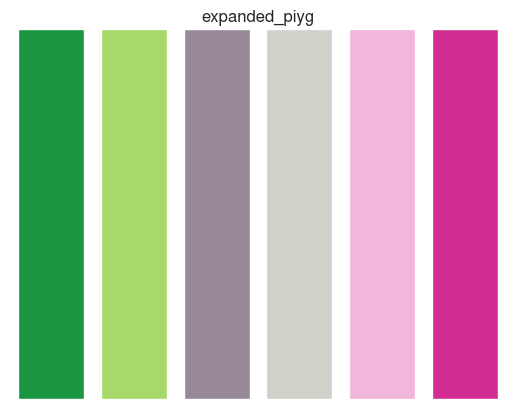

['#1a9641', '#a6d96a', '#978897', '#d1d1ca', '#f1b6da', '#d02c91']


In [179]:
# Get the color palette of the PiYG color map
expanded_piyg = visualise.color_palette('expanded_piyg').colors

sns.set_palette(expanded_piyg)

# Display the colors in the PiYG color map
visualise.show_colors('expanded_piyg')
print(expanded_piyg)


# Output

In [11]:
output_dir = '/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/thresholded_480_jun23/'
os.makedirs(output_dir, exist_ok = True)

### Quick plot to show variation to atb response

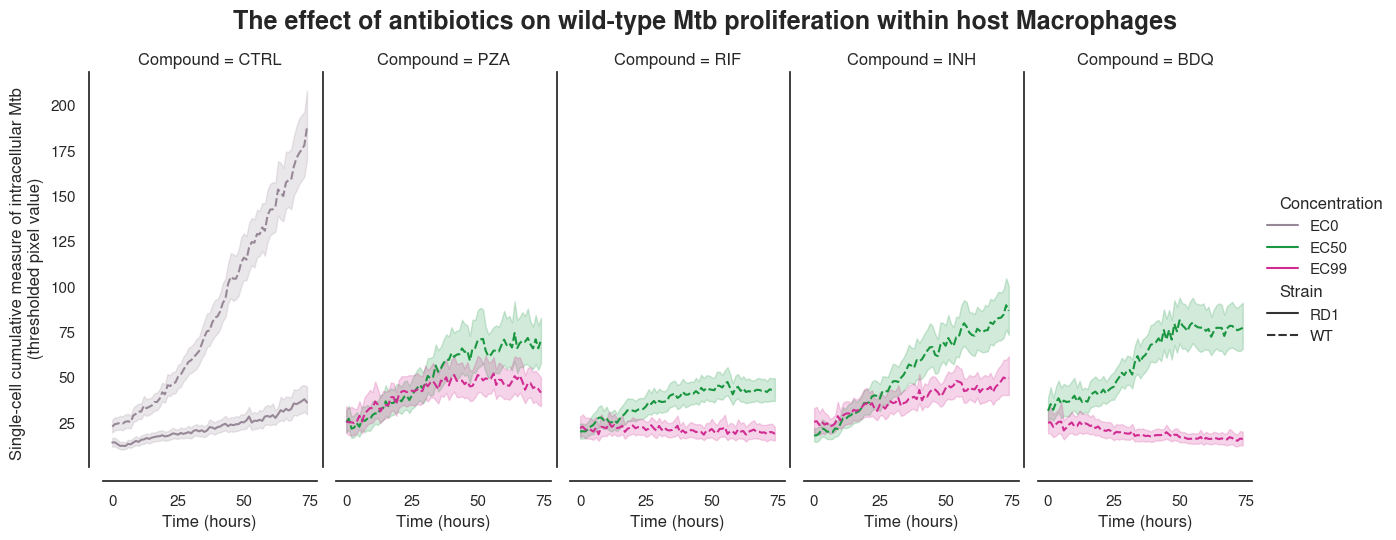

In [78]:
g = sns.relplot(data = df, 
            x = 'Time (hours)', 
            y = 'Intracellular thresholded Mtb content', 
            hue = 'Concentration', 
            style = 'Strain',
            col= 'Compound',
            kind = 'line',
            aspect = 0.5,
            palette=[ expanded_piyg[2], expanded_piyg[0],  expanded_piyg[-1],]
           )
# # g.set_ylabels("Intracellular Mtb content")
# g.set_ylabels("Intracellular $\\mathit{Mycobacterium tuberculosis}$")
# plt.gcf().suptitle('The effect of antibiotics on wild-type **$\\mathit{Mycobacterium tuberculosis}$** (Mtb) proliferation within host Macrophages', 
#                    fontsize=14, fontweight='bold', 
#                   y = 1.05)
# plt.rc('text', usetex=False)
# g.set_ylabels("Intracellular Mtb content")
g.set_ylabels("Single-cell cumulative measure of intracellular Mtb \n (thresholded pixel value)")
plt.gcf().suptitle('The effect of antibiotics on wild-type Mtb proliferation within host Macrophages', 
                   fontsize=18, fontweight='bold', 
                  y = 1.05)
plt.rc('text', usetex=False)
sns.despine(offset = 10)
plt.savefig(os.path.join(output_dir, 'ATB_effect_Mtb.png'), bbox_inches = 'tight', dpi = 314)

# How many cells are truly permissive ie deltaMtb>0

#### What do the different distributions of deltaMtb look like?

In [63]:
df_delta_mtb = df.drop_duplicates(subset=['delta Mtb raw', 'delta Mtb max raw','delta Mtb max smooth', 'delta Mtb max fold-change'])
df_delta_mtb

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,delta Mtb/dt,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID,dMtb
0,0,708.125061,77.589088,3568.950308,391.049006,0.0,0.0,1.0,42556.0,365.408905,...,0.418707,0.813310,0.0,RD1,CTRL,EC0,433,"(3, 4)",433.3.4,0.095232
42,0,261.683105,4.945100,1318.882852,24.923306,0.0,0.0,0.0,6754.0,355.006958,...,-0.142246,0.913146,0.0,RD1,CTRL,EC0,424,"(3, 4)",424.3.4,-0.000112
89,0,349.589508,8.074520,1761.931121,40.695581,0.0,0.0,0.0,13672.0,344.202454,...,0.000000,0.957093,0.0,RD1,CTRL,EC0,425,"(3, 4)",425.3.4,0.000000
152,0,457.172943,8.791715,2304.151633,44.310242,1.0,1.0,0.0,20542.0,343.157196,...,0.346945,0.929721,0.0,RD1,CTRL,EC0,426,"(3, 4)",426.3.4,0.000586
226,0,663.630920,10.924337,3344.699839,55.058660,0.0,0.0,0.0,20098.0,353.067780,...,0.031179,0.805467,0.0,RD1,CTRL,EC0,427,"(3, 4)",427.3.4,0.000544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701271,33,660.136597,577.060730,3327.088447,2908.386079,0.0,0.0,0.0,47448.0,377.264587,...,-0.000397,0.952213,0.0,WT,BDQ,EC99,2297,"(6, 9)",2297.6.9,0.000032
701313,33,224.372467,131.369995,1130.837234,662.104775,1.0,1.0,1.0,98867.0,373.245178,...,0.050624,0.885194,0.0,WT,BDQ,EC99,2292,"(6, 9)",2292.6.9,-0.000153
701355,33,1106.007935,1032.619019,5574.279990,5204.399854,0.0,0.0,1.0,53641.0,366.914032,...,0.366863,0.950100,0.0,WT,BDQ,EC99,2286,"(6, 9)",2286.6.9,0.000089
701397,34,477.689026,538.676697,2407.552690,2714.930552,0.0,0.0,0.0,36503.0,356.196930,...,0.374870,0.796381,0.0,WT,BDQ,EC99,2324,"(6, 9)",2324.6.9,0.000167


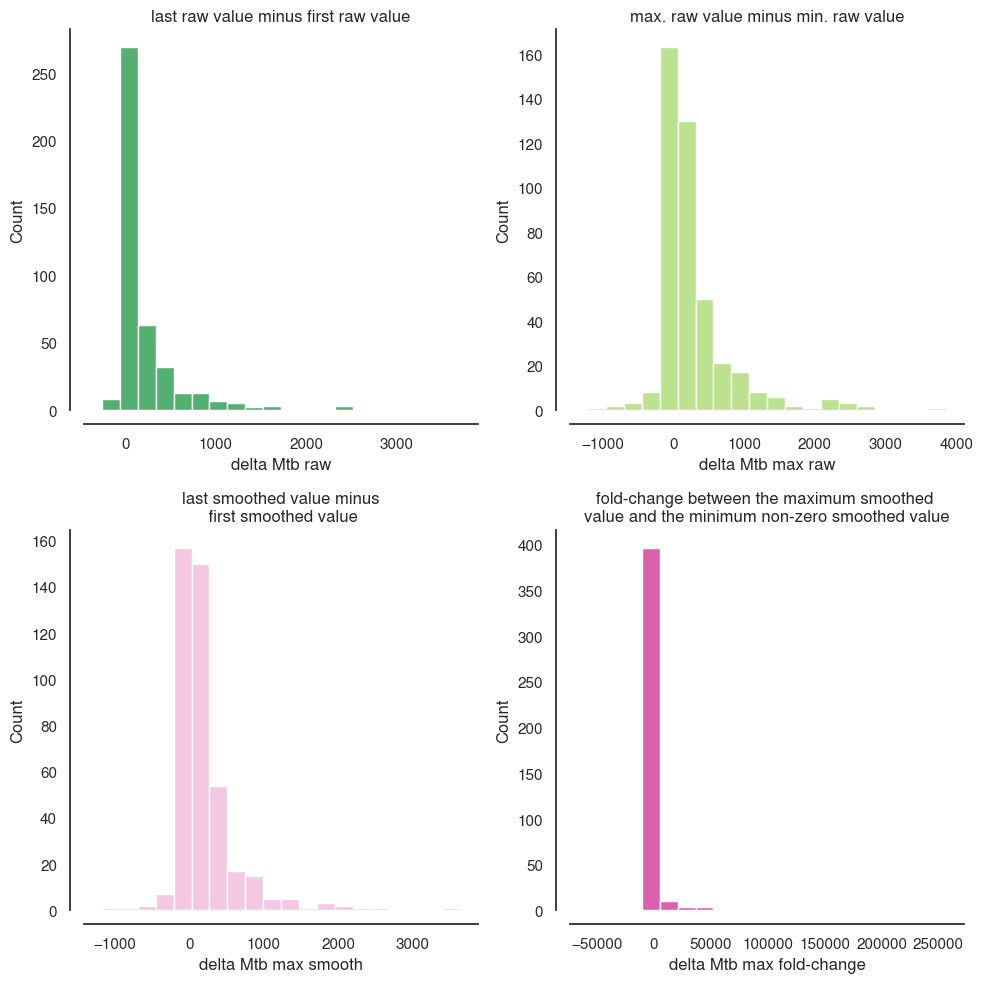

In [389]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.histplot(data=df_delta_mtb[df_delta_mtb['Acquisition ID']==(3,5)], x='delta Mtb raw', kde=False, ax=axes[0, 0], bins = 20, color=expanded_piyg[0])
axes[0, 0].set_title('last raw value minus first raw value')
# axes[0, 0].set_ylim([0, 300])  # set the ylim for the first subplot

sns.histplot(data=df_delta_mtb[df_delta_mtb['Acquisition ID']==(3,5)], x='delta Mtb max raw', kde=False, ax=axes[0, 1], bins = 20, color=expanded_piyg[1])
axes[0, 1].set_title('max. raw value minus min. raw value')
# axes[0, 1].set_ylim([0, 300])  # set the ylim for the second subplot

sns.histplot(data=df_delta_mtb[df_delta_mtb['Acquisition ID']==(3,5)], x='delta Mtb max smooth', kde=False, ax=axes[1, 0], bins = 20, color=expanded_piyg[-2])
axes[1, 0].set_title('last smoothed value minus\n first smoothed value')
# axes[1, 0].set_ylim([0, 300])  # set the ylim for the third subplot

sns.histplot(data=df_delta_mtb[df_delta_mtb['Acquisition ID']==(3,5)], x='delta Mtb max fold-change', kde=False, ax=axes[1, 1], bins = 20, color=expanded_piyg[-1])
axes[1, 1].set_title('fold-change between the maximum smoothed \nvalue and the minimum non-zero smoothed value')
# axes[1, 1].set_ylim([0, 100])  # set the ylim for the fourth subplot

sns.despine(offset=10)

plt.tight_layout()

plt.savefig(os.path.join(output_dir, 'single-cell_signal/delta_mtb_considerations/delta_mtb_approach_hist_unclipped_3,5.png'), 
           bbox_inches = 'tight', dpi = 314)

plt.show() 


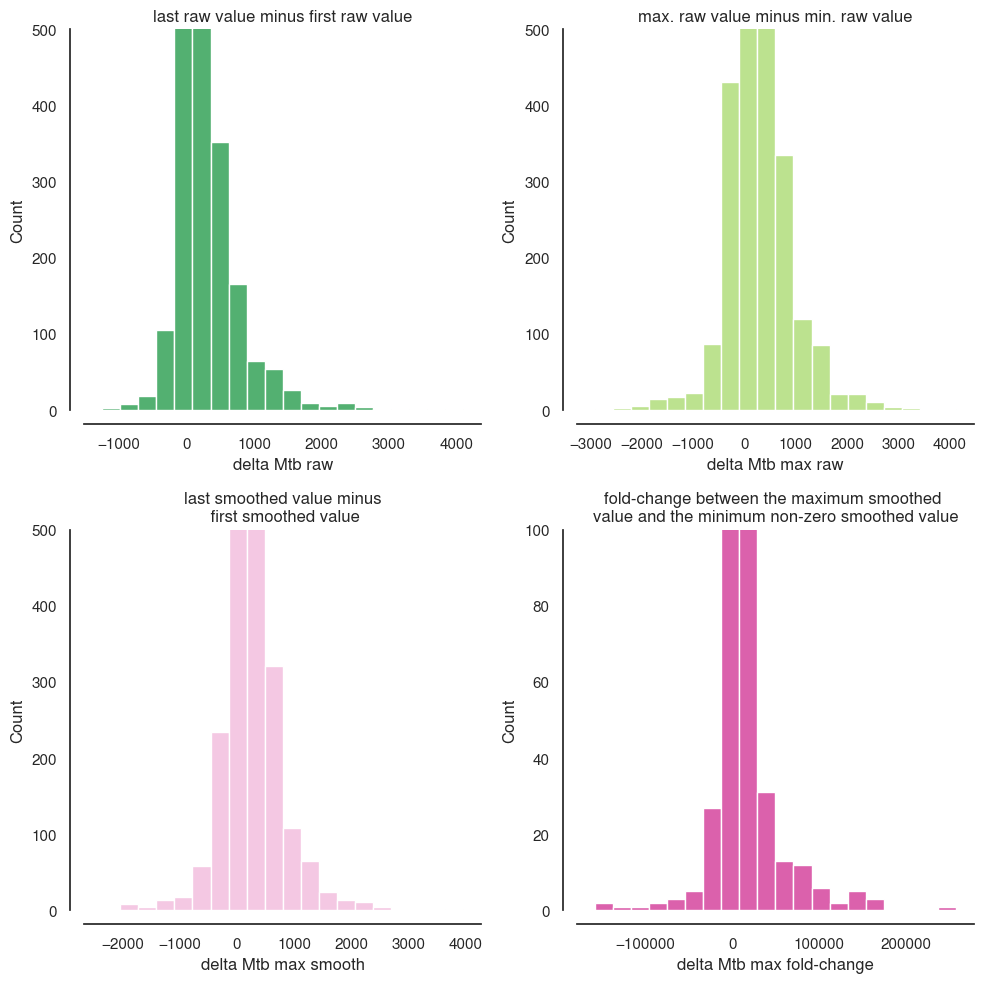

In [384]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.histplot(data=df_delta_mtb, x='delta Mtb raw', kde=False, ax=axes[0, 0], bins = 20, color=expanded_piyg[0])
axes[0, 0].set_title('last raw value minus first raw value')
axes[0, 0].set_ylim([0, 500])  # set the ylim for the first subplot

sns.histplot(data=df_delta_mtb, x='delta Mtb max raw', kde=False, ax=axes[0, 1], bins = 20, color=expanded_piyg[1])
axes[0, 1].set_title('max. raw value minus min. raw value')
axes[0, 1].set_ylim([0, 500])  # set the ylim for the second subplot

sns.histplot(data=df_delta_mtb, x='delta Mtb max smooth', kde=False, ax=axes[1, 0], bins = 20, color=expanded_piyg[-2])
axes[1, 0].set_title('last smoothed value minus\n first smoothed value')
axes[1, 0].set_ylim([0, 500])  # set the ylim for the third subplot

sns.histplot(data=df_delta_mtb, x='delta Mtb max fold-change', kde=False, ax=axes[1, 1], bins = 20, color=expanded_piyg[-1])
axes[1, 1].set_title('fold-change between the maximum smoothed \nvalue and the minimum non-zero smoothed value')
axes[1, 1].set_ylim([0, 100])  # set the ylim for the fourth subplot

sns.despine(offset=10)

plt.tight_layout()

plt.savefig(os.path.join(output_dir, 'single-cell_signal/delta_mtb_considerations/delta_mtb_approach_hist_clipped.png'), 
           bbox_inches = 'tight', dpi = 314)

plt.show() 


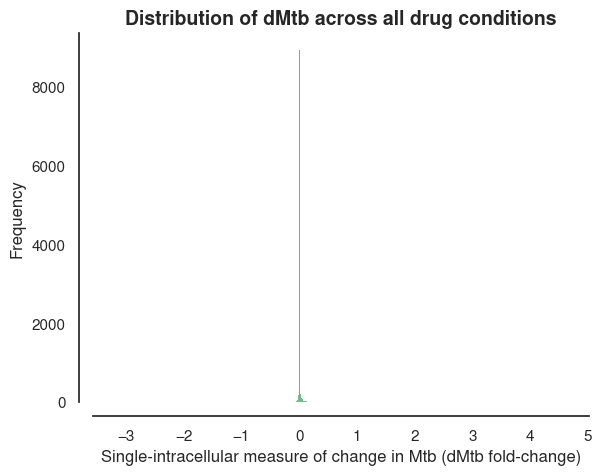

In [145]:

sns.histplot(data=df_delta_mtb, x='dMtb', kde=False, bins = 400, color=expanded_piyg[0])
sns.despine(offset=10)
# plt.ylim(0,2000)
plt.xlabel('Single-intracellular measure of change in Mtb (dMtb fold-change)')
# plt.savefig(os.path.join(output_dir, 'single-cell_signal/delta_mtb_considerations/delta_mtb_norm_hist_clipped.png'), 
#            bbox_inches = 'tight', dpi = 314)
plt.ylabel('Frequency')
plt.title('Distribution of dMtb across all drug conditions', 
                   fontsize=14, fontweight='bold', )
#                   y = 1.05)
plt.savefig(f'/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/thresholded_480_jun23/dmtb/dmtb_all_drug_conditions.png', 
           bbox_inches = 'tight', dpi = 314)
plt.show() 

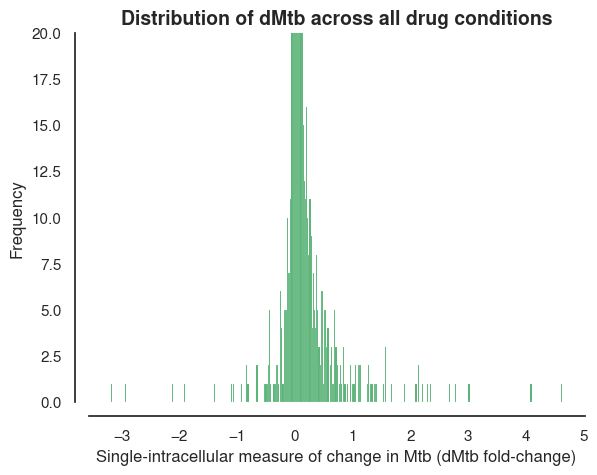

In [148]:
sns.histplot(data=df_delta_mtb, x='dMtb', kde=False, bins = 400, color=expanded_piyg[0])
sns.despine(offset=10)
plt.ylim(0,20)
plt.xlabel('Single-intracellular measure of change in Mtb (dMtb fold-change)')
# plt.savefig(os.path.join(output_dir, 'single-cell_signal/delta_mtb_considerations/delta_mtb_norm_hist_clipped.png'), 
#            bbox_inches = 'tight', dpi = 314)
plt.ylabel('Frequency')
plt.title('Distribution of dMtb across all drug conditions', 
                   fontsize=14, fontweight='bold', )
#                   y = 1.05)
plt.savefig(f'/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/thresholded_480_jun23/dmtb/dmtb_all_drug_conditions_clipped.png', 
           bbox_inches = 'tight', dpi = 314)
plt.show() 

In [207]:
# "Melt" the DataFrame to "long-form" or "tidy" representation
df_melted = pd.melt(df_delta_mtb, ["Compound", "Concentration"], var_name="measurement")
df_melted = df_melted[df_melted['measurement'] == 'dMtb']
# Rename the 'value' column to 'dMtb'
df_melted = df_melted.rename(columns={'value': 'dMtb'})



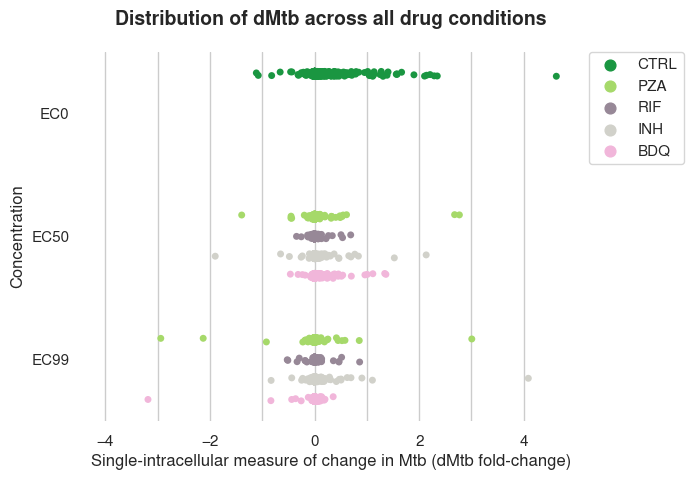

In [299]:
# Initialize the figure
f, ax = plt.subplots()


# Show each observation with a scatterplot
sns.stripplot(
    data=df_melted, x="dMtb", y="Concentration", hue="Compound",
    dodge=True, alpha=1, zorder=5, ax=ax, palette = expanded_piyg
)

# Move the legend outside the plot on the right-hand side
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
sns.despine(offset=10, 
            bottom=True, 
            left=True
           )
# # Show the conditional means using pointplot
# sns.pointplot(
#     data=df_melted, x="dMtb", y="Concentration", hue="Compound",
#     join=False, 
#     dodge=.8 - .8 / len(df_delta_mtb['Compound'].unique()), 
#     palette=expanded_piyg,
#     markers="d", scale=.75, errorbar=None, ax=ax, legend = None
# )
# Add vertical lines
vertical_lines = np.linspace(-4,4, 9)  # Example values, modify according to your needs
for line in vertical_lines:
    plt.axvline(x=line, color='black', linestyle='-', linewidth=1, alpha = 0.2)
plt.title('Distribution of dMtb across all drug conditions', 
                   fontsize=14, fontweight='bold', 
                  y = 1.05)
plt.xlabel('Single-intracellular measure of change in Mtb (dMtb fold-change)')
# Show the plot
# plt.savefig(f'/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/thresholded_480_jun23/dmtb/dmtb_all_drug_scatter.png', 
#            bbox_inches = 'tight', dpi = 314)
plt.show() 

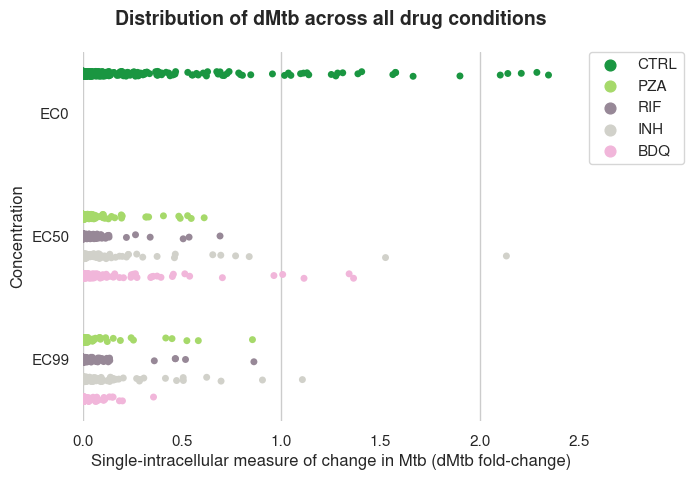

In [304]:
# Initialize the figure
f, ax = plt.subplots()


# Show each observation with a scatterplot
sns.stripplot(
    data=df_melted, x="dMtb", y="Concentration", hue="Compound",
    dodge=True, alpha=1, zorder=5, ax=ax, palette = expanded_piyg
)

# Move the legend outside the plot on the right-hand side
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
sns.despine(offset=10, 
            bottom=True, 
            left=True
           )
# # Show the conditional means using pointplot
# sns.pointplot(
#     data=df_melted, x="dMtb", y="Concentration", hue="Compound",
#     join=False, 
#     dodge=.8 - .8 / len(df_delta_mtb['Compound'].unique()), 
#     palette=expanded_piyg,
#     markers="d", scale=.75, errorbar=None, ax=ax, legend = None
# )
# Add vertical lines
# vertical_lines = np.linspace(-4,4, 9)  # Example values, modify according to your needs
for line in vertical_lines:
    plt.axvline(x=line, color='black', linestyle='-', linewidth=1, alpha = 0.2)
plt.title('Distribution of dMtb across all drug conditions', 
                   fontsize=14, fontweight='bold', 
                  y = 1.05)
plt.xlabel('Single-intracellular measure of change in Mtb (dMtb fold-change)')
plt.xlim(0, 2.5)
# Show the plot
# plt.savefig(f'/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/thresholded_480_jun23/dmtb/dmtb_all_drug_scatter.png', 
#            bbox_inches = 'tight', dpi = 314)
plt.show() 

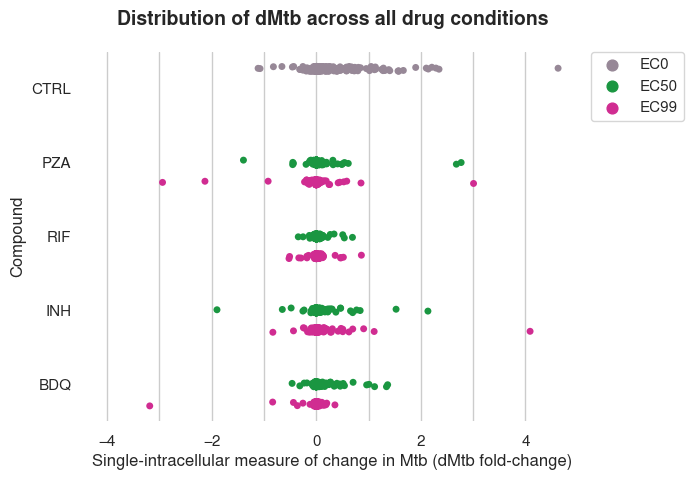

In [291]:
# Initialize the figure
f, ax = plt.subplots()


# Show each observation with a scatterplot
sns.stripplot(
    data=df_melted, x="dMtb", y="Compound", hue="Concentration",
    dodge=True, alpha=1, zorder=5, ax=ax, palette = [expanded_piyg[2], expanded_piyg[0], expanded_piyg[-1]]
)

# Move the legend outside the plot on the right-hand side
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
sns.despine(offset=10, 
            bottom=True, 
            left=True
           )

# Add vertical lines
vertical_lines = np.linspace(-4,4, 9)  # Example values, modify according to your needs
for line in vertical_lines:
    plt.axvline(x=line, color='black', linestyle='-', linewidth=1, alpha = 0.2)
plt.title('Distribution of dMtb across all drug conditions', 
                   fontsize=14, fontweight='bold', 
                  y = 1.05)
plt.xlabel('Single-intracellular measure of change in Mtb (dMtb fold-change)')
# Show the plot
plt.savefig(f'/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/thresholded_480_jun23/dmtb/dmtb_all_drug_scatter_alt.png', 
           bbox_inches = 'tight', dpi = 314)
plt.show() 

In [214]:
# Assuming 'df_delta_Mtb' is your DataFrame
top_rows = df_delta_mtb.nlargest(10, 'dMtb')
top_rows

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,delta Mtb/dt,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID,dMtb
41983,0,519.976685,1041.591919,2620.682490,5249.623271,0.0,0.0,1.0,33191.0,370.089539,...,8.268794,0.696256,0.0,WT,CTRL,EC0,280,"(3, 5)",280.3.5,4.624052
657222,0,388.780487,668.168152,1959.453655,3367.567485,0.0,0.0,1.0,23630.0,363.540588,...,11.490217,0.810668,0.0,WT,INH,EC99,96,"(6, 8)",96.6.8,4.088434
613711,18,195.733536,157.711990,986.497020,794.868431,0.0,0.0,0.0,39243.0,379.313904,...,-1.144762,0.915205,0.0,WT,PZA,EC99,1925,"(6, 6)",1925.6.6,3.007196
69880,0,883.031555,1056.135254,4450.479038,5322.921680,1.0,1.0,1.0,12569.0,377.961823,...,89.769524,0.658125,0.0,WT,PZA,EC50,299,"(3, 6)",299.3.6,2.769864
77597,7,180.348572,225.591080,908.956802,1136.979042,1.0,1.0,1.0,16899.0,387.806305,...,8.437622,0.819995,0.0,WT,PZA,EC50,1251,"(3, 6)",1251.3.6,2.678517
36197,0,933.322388,697.360840,4703.944834,3514.698633,0.0,0.0,1.0,18897.0,377.389099,...,11.976203,0.827378,0.0,WT,CTRL,EC0,106,"(3, 5)",106.3.5,2.346850
34092,0,1013.018066,613.704102,5105.611055,3093.068672,0.0,0.0,1.0,33571.0,390.042694,...,6.309599,0.856875,0.0,WT,CTRL,EC0,484,"(3, 5)",484.3.5,2.288280
34737,0,907.020264,626.401550,4571.382129,3157.063813,0.0,0.0,1.0,14859.0,380.547668,...,9.452961,0.487975,0.0,WT,CTRL,EC0,539,"(3, 5)",539.3.5,2.209745
391455,0,723.685181,491.966370,3647.373311,2479.510503,0.0,0.0,1.0,18043.0,371.835907,...,4.397746,0.787266,0.0,WT,CTRL,EC0,525,"(5, 5)",525.5.5,2.141826
136595,1,692.762024,1189.384521,3491.520601,5994.497988,0.0,0.0,1.0,16521.0,362.497620,...,12.065323,0.655386,0.0,WT,INH,EC50,724,"(3, 8)",724.3.8,2.134655


Text(10, 500, 'Gradient of Mtb = 8.268794172508796')

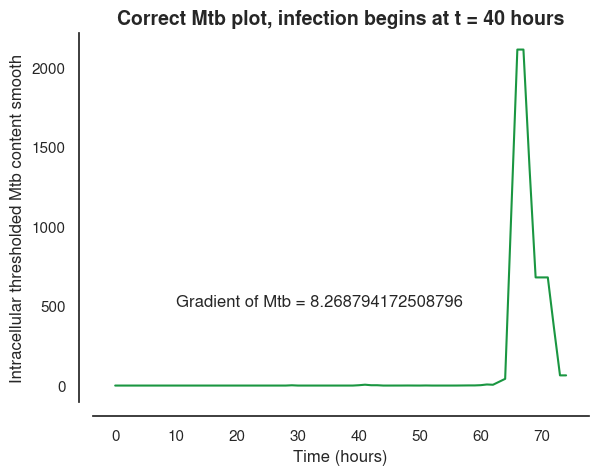

In [150]:
unique_ID = '280.3.5'
sns.lineplot(data = df[df['Unique ID']==unique_ID], y = 'Intracellular thresholded Mtb content smooth', x = 'Time (hours)')
sns.despine(offset=10)
plt.title('Correct Mtb plot, infection begins at t = 40 hours', 
                   fontsize=14, fontweight='bold', )
#                   y = 1.05)
gradient = df[df['Unique ID']==unique_ID]['delta Mtb/dt'].iloc[0]
plt.text(x = 10, y = 500, s = f'Gradient of Mtb = {gradient}')
# plt.savefig(f'/mnt/DATA/macrohet/results/preliminary_sc_measures/sc_graphs/jun23_error/correct_{unique_ID}_cell_ID_switch_mtb_plot.png', 
#            bbox_inches = 'tight', dpi = 314)

### Many sc

In [275]:
top_rows =df_delta_mtb.nlargest(7, 'dMtb')

In [281]:
subset_df.dMtb.iloc[0]

2.288280132472997

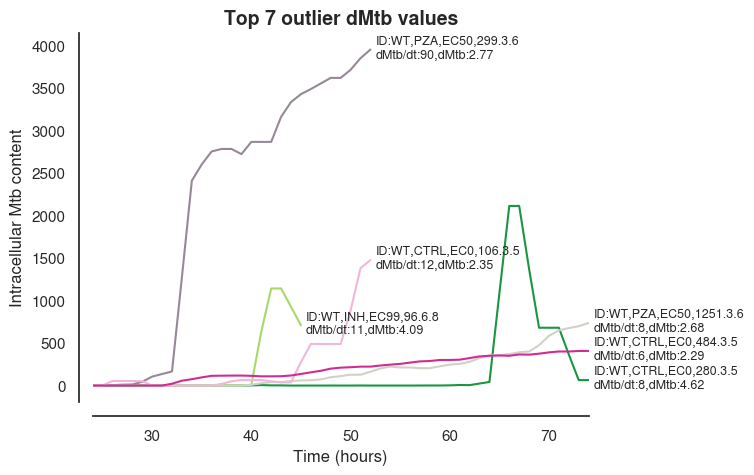

In [303]:
for i, unique_ID in enumerate(top_rows['Unique ID']):
    subset_df = df[df['Unique ID']==unique_ID]
    strain = subset_df['Strain'].iloc[0]
    compound = subset_df['Compound'].iloc[0]
    concentration = subset_df['Concentration'].iloc[0]
    ID = subset_df['Unique ID'].iloc[0]
    label = f'{strain},{compound},{concentration},{ID}'
#     label = f'{ID}'

    gradient = subset_df['delta Mtb/dt'].iloc[0]
    if gradient<0:
        continue
    x,y = subset_df['Time (hours)'].iloc[-1], subset_df['Intracellular thresholded Mtb content smooth'].iloc[-1]
    plt.text(x = x+0.5, y = y-100, s = f'ID:{label}\ndMtb/dt:{gradient:.0f},dMtb:{subset_df.dMtb.iloc[0]:.2f}', size =9)

    sns.lineplot(data = subset_df, 
                 y = 'Intracellular thresholded Mtb content smooth', 
                 x = 'Time (hours)', 
#                  label = label
                 )
sns.despine(offset=10)
plt.title('Top 7 outlier dMtb values', 
               fontsize=14, fontweight='bold', )
#                   y = 1.05)
plt.ylabel('Intracellular Mtb content')
plt.xlim(24,74)
# plt.text(x = 10, y = 500, s = f'Gradient of Mtb = {gradient}')
plt.savefig(f'/mnt/DATA/macrohet/results/preliminary_sc_measures/sc_graphs/jun23_dmtb_outliers/top7_dmtb_plot.png', 
           bbox_inches = 'tight', dpi = 314)

In [275]:
top_rows =df_delta_mtb.nlargest(7, 'dMtb')

In [281]:
subset_df.dMtb.iloc[0]

2.288280132472997

(0.0, 500.0)

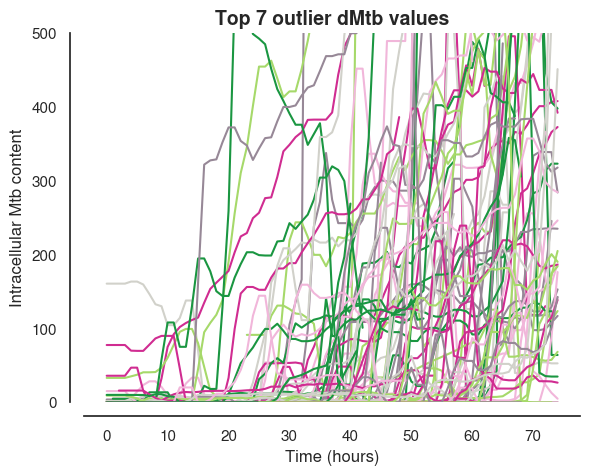

In [308]:
top_rows =df_delta_mtb.nlargest(100, 'dMtb')
for i, unique_ID in enumerate(top_rows['Unique ID']):
    subset_df = df[df['Unique ID']==unique_ID]
    strain = subset_df['Strain'].iloc[0]
    compound = subset_df['Compound'].iloc[0]
    concentration = subset_df['Concentration'].iloc[0]
    ID = subset_df['Unique ID'].iloc[0]
    label = f'{strain},{compound},{concentration},{ID}'
    label = f'{ID}'

    gradient = subset_df['delta Mtb/dt'].iloc[0]
    if gradient<0:
        continue
    x,y = subset_df['Time (hours)'].iloc[-1], subset_df['Intracellular thresholded Mtb content smooth'].iloc[-1]
#     plt.text(x = x+0.5, y = y-100, s = f'ID:{label}\ndMtb/dt:{gradient:.0f},dMtb:{subset_df.dMtb.iloc[0]:.2f}', size =9)

    sns.lineplot(data = subset_df, 
                 y = 'Intracellular thresholded Mtb content smooth', 
                 x = 'Time (hours)', 
#                  label = label
                 )
sns.despine(offset=10)
plt.title('Top 7 outlier dMtb values', 
               fontsize=14, fontweight='bold', )
#                   y = 1.05)
plt.ylabel('Intracellular Mtb content')
plt.ylim(0,500)
# plt.text(x = 10, y = 500, s = f'Gradient of Mtb = {gradient}')
# plt.savefig(f'/mnt/DATA/macrohet/results/preliminary_sc_measures/sc_graphs/jun23_dmtb_outliers/top7_dmtb_plot.png', 
#            bbox_inches = 'tight', dpi = 314)